In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
hot = pd.read_csv('data/hot100/hot100.csv')

In [8]:
hot5870 = hot[(hot['date'] > '1958-01-01') & (hot['date'] < '1970-12-31')]

In [10]:
hot5870.index = hot5870.index + 1

In [13]:
hot5870['inverse_score'] = 101 - hot5870['position']

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
hot5870.drop('position',axis = 1 , inplace = True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
inverse_sum_df = hot5870.groupby(['song','artist'])['inverse_score'].agg(['sum','count']).reset_index()

#Arrange the scores in Descending order because the highest score should be on the top.

In [22]:
inverse_sum_df.sort_values('sum',ascending = False,inplace = True) 

In [25]:
inverse_sum_df.reset_index(inplace = True)
inverse_sum_df.index = inverse_sum_df.index + 1

In [28]:
inverse_sum_df.drop('index',axis = 1,inplace = True)
inverse_sum_df.rename(columns = {'sum' : 'inverse_score', 'count' : 'number_of_weeks' },inplace = True)

In [30]:
inverse_sum_df['SONG_RANK']  =  inverse_sum_df.index

In [32]:
inverse_sum_df.to_csv('Song_Rank.csv',index = False)

In [35]:
genre = pd.read_csv('genre_All_songs.csv',encoding = "ISO-8859-1")

In [37]:
Song_rank_genre = pd.merge(inverse_sum_df,genre,how='inner',on = ['song','artist'])

In [38]:
Song_rank_genre.shape

(8397, 6)

In [40]:
Song_rank_genre[ Song_rank_genre['song'] == 'Heartaches By The Number']

,song,artist,inverse_score,number_of_weeks,SONG_RANK,genre
32,Heartaches By The Number,Guy Mitchell,1602,20,33,Pop
3456,Heartaches By The Number,Johnny Tillotson,369,8,3463,Rock


In [41]:
year = pd.read_csv('Final_Genre_Year.csv')

In [442]:
year.drop(['lastfm_count','new_popularity' ,'genre'],axis = 1,inplace = True)

In [443]:
year.head()

,song,artist,year
0,Harlem Nocturne,The Viscounts,1960
1,Never On Sunday,Don Costa And His Orchestra And Chorus,1960
2,Robbin' The Cradle,Tony Bellus,1959
3,Moon River,Henry Mancini And His Orchestra,1961
4,The Little Drummer Boy,The Harry Simeone Chorale,1958


In [47]:
Final_DF = pd.merge(Song_rank_genre,year,how='inner',on = ['song','artist','genre'])

In [48]:
Final_DF.reset_index(inplace = True)
Final_DF.index = Final_DF.index  + 1

In [50]:
Final_DF.drop('index',axis = 1,inplace = True)
Final_DF.to_csv('Df5870.csv')

In [52]:
Final_DF.sort_values('new_popularity',ascending = True,inplace = True)

In [53]:
Final_DF.head()

,song,artist,inverse_score,number_of_weeks,SONG_RANK,genre,lastfm_count,new_popularity,year
5441,Paranoid,Black Sabbath,138,5,5450,Rock,7846242,1,1970
511,The Sound Of Silence,Simon & Garfunkel,1092,14,513,Pop,7006004,2,1965
860,"Paint It, Black",The Rolling Stones,963,11,862,Pop,6971647,3,1966
175,Let It Be,The Beatles,1287,14,176,Rock,6917316,4,1970
867,Yesterday,The Beatles,961,11,869,Rock,6647511,5,1965


In [55]:
import statsmodels.formula.api as smf

# create a fitted model in one line
lm = smf.ols(formula='new_popularity ~ SONG_RANK', data=Final_DF).fit()

# print the coefficients
lm.params

Intercept    2196.431388
SONG_RANK       0.476689
dtype: float64

In [57]:
0.476689*5450 +  2196.431388

4794.3864379999995

In [58]:
X_new = pd.DataFrame({'SONG_RANK': [Final_DF.SONG_RANK.min(), Final_DF.SONG_RANK.max()]})
X_new.head()

,SONG_RANK
0,1
1,8408


In [60]:
preds = lm.predict(X_new)
preds

0    2196.908076
1    6204.429236
dtype: float64

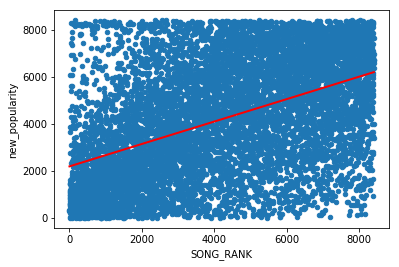

In [61]:
# first, plot the observed data
Final_DF.plot(kind='scatter', x='SONG_RANK', y='new_popularity')

# then, plot the least squares line
plt.plot(X_new, preds, c='red', linewidth=2)

In [62]:
# print the R-squared value for the model
lm.rsquared

0.22740518441540358

In [63]:
# create a fitted model in one line
lm = smf.ols(formula='new_popularity ~ SONG_RANK + year + genre', data=Final_DF).fit()

# print the coefficients
lm.params

Intercept               179406.053417
genre[T.Classical]        1221.575563
genre[T.Electronica]       310.819696
genre[T.Jazz]             -296.530990
genre[T.Other]             218.359935
genre[T.Pop]              -301.369700
genre[T.Rock]            -1100.604566
genre[T.Soundtrack]        119.326241
genre[T.Traditional]     -1088.998647
genre[T.Urban]           -1146.032132
SONG_RANK                    0.471472
year                       -89.783865
dtype: float64

In [64]:
# print a summary of the fitted model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         new_popularity   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     287.4
Date:                Sun, 26 Nov 2017   Prob (F-statistic):               0.00
Time:                        23:13:11   Log-Likelihood:                -71563.
No. Observations:                7930   AIC:                         1.432e+05
Df Residuals:                    7918   BIC:                         1.432e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.794e+05   1.28e+04     14.056      0.000    1.54e+05    2.04e+05
genre[T.Classical]    1221.5756    530.400      2.303      0.021     181.851    2261.300
genre[T.Electronica]   310.8197    437.068      0.711      0.477    -545.949    1167.588
genre[T.Jazz]         -296.5310    286.664     -1.034      0.301    -858.468     265.406
genre[T.Other]         218.3599    293.288      0.745      0.457    -356.561     793.281
genre[T.Pop]          -301.3697    268.004     -1.124      0.261    -826.728     223.988
genre[T.Rock]        -1100.6046    264.346     -4.164      0.000   -1618.792    -582.417
genre[T.Soundtrack]    119.3262    405.953      0.294      0.769    -676.448     915.101
genre[T.Traditional] -1088.9986    271.105     -4.017      0.000   -1620.436    -557.562
genre[T.Urban]       -1146.0321    265.914     -4.310      0.000   -1667.294    -624.770
SONG_RANK                0.4715      0.010     48.674      0.000       0.452       0.490
year                   -89.7839      6.497    -13.819      0.000    -102.520     -77.048
==============================================================================
Omnibus:                       66.143   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.214
Skew:                           0.084   Prob(JB):                     3.39e-11
Kurtosis:                       2.657   Cond. No.                     2.85e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
lm.rsquared

0.28535740647156671

In [69]:
# create X and y
feature_cols = ['SONG_RANK', 'year' ]
X = Final_DF[feature_cols]
y = Final_DF.new_popularity

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print (lm.intercept_)
print (lm.coef_)

201999.628527
[   0.48041157 -101.7230304 ]


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [71]:
# pair the feature names with the coefficients
zip(feature_cols, lm.coef_)

In [73]:
# calculate the R-squared
lm.score(X, y)

0.24938727297443278

In [74]:
artist = pd.read_csv("grammy.csv")

In [85]:
artist.columns

Index(['Winner', 'Country', 'Song', 'Artist', 'Nominees', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')

In [86]:
artist.rename(columns={'Artist' : 'artist'},inplace = True)

In [87]:
df = pd.merge(Final_DF,artist,how = 'inner' ,on ='artist')

In [89]:
df.drop(['Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12','Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16'],axis=1,inplace = True)

In [91]:
df.groupby('artist').count()

,song,inverse_score,number_of_weeks,SONG_RANK,genre,lastfm_count,new_popularity,year,Winner,Country,Song,Nominees,Unnamed: 5,Unnamed: 6
artist,,,,,,,,,,,,,,
Barbra Streisand,11,11,11,11,10,11,11,11,11,11,11,11,0,0
Domenico Modugno,2,2,2,2,1,2,2,2,2,2,2,2,2,0
Eric Clapton,2,2,2,2,2,2,2,2,2,2,2,2,2,1
Henry Mancini,2,2,2,2,2,2,2,2,2,2,2,2,2,1
Joe South,5,5,5,5,5,5,5,5,5,5,5,5,5,5
Johnny Horton,8,8,8,8,8,8,8,8,8,8,8,8,8,0
Judy Collins,6,6,6,6,6,6,6,6,6,6,6,6,6,0
Louis Armstrong,2,2,2,2,2,2,2,2,2,2,2,2,2,2
O.C. Smith,8,8,8,8,8,8,8,8,8,8,8,8,8,0


In [92]:
Final_DF[Final_DF['artist'] == 'Barbra Streisand']

,song,artist,inverse_score,number_of_weeks,SONG_RANK,genre,lastfm_count,new_popularity,year
302,People,Barbra Streisand,1193,19,303,Pop,113811,961,1964
5949,My Man,Barbra Streisand,92,6,5959,Pop,81900,1166,1965
3053,Stoney End,Barbra Streisand,433,9,3057,Pop,46659,1604,1970
3021,Second Hand Rose,Barbra Streisand,438,9,3025,Pop,32151,1920,1965
4023,He Touched Me,Barbra Streisand,300,10,4029,Pop,28331,2036,1965
3192,Funny Girl,Barbra Streisand,409,9,3197,Pop,20420,2350,1964
6351,Free Again,Barbra Streisand,60,4,6361,Pop,7922,3376,1966
6257,Why Did I Choose You,Barbra Streisand,66,5,6267,Pop,4981,3834,1965
8228,"Sam, You Made The Pants Too Long",Barbra Streisand,3,1,8239,NaN,2587,4521,1966
7495,Where Am I Going?,Barbra Streisand,14,2,7506,Pop,2275,4657,1966


In [94]:
artist.rename(columns={'Song' : 'song'},inplace = True)
df2 = pd.merge(Final_DF,artist,how = 'inner' ,on =['song','artist'])

In [98]:
copy = Final_DF.copy()

In [99]:
copy_gen = pd.get_dummies(copy['genre'])

In [100]:
copy_gen.head()

,Alternative & Punk,Classical,Electronica,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban
5441,0,0,0,0,0,0,1,0,0,0
511,0,0,0,0,0,1,0,0,0,0
860,0,0,0,0,0,1,0,0,0,0
175,0,0,0,0,0,0,1,0,0,0
867,0,0,0,0,0,0,1,0,0,0


In [102]:
co_ge_me = pd.concat([copy,copy_gen],axis =1)

In [103]:
co_ge_me

,song,artist,inverse_score,number_of_weeks,SONG_RANK,genre,lastfm_count,new_popularity,year,Alternative & Punk,Classical,Electronica,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban
5441,Paranoid,Black Sabbath,138,5,5450,Rock,7846242,1,1970,0,0,0,0,0,0,1,0,0,0
511,The Sound Of Silence,Simon & Garfunkel,1092,14,513,Pop,7006004,2,1965,0,0,0,0,0,1,0,0,0,0
860,"Paint It, Black",The Rolling Stones,963,11,862,Pop,6971647,3,1966,0,0,0,0,0,1,0,0,0,0
175,Let It Be,The Beatles,1287,14,176,Rock,6917316,4,1970,0,0,0,0,0,0,1,0,0,0
867,Yesterday,The Beatles,961,11,869,Rock,6647511,5,1965,0,0,0,0,0,0,1,0,0,0
3908,Immigrant Song,Led Zeppelin,313,6,3914,Rock,6268358,6,1970,0,0,0,0,0,0,1,0,0,0
406,Help!,The Beatles,1136,13,407,Rock,6265950,7,1965,0,0,0,0,0,0,1,0,0,0
1085,Like A Rolling Stone,Bob Dylan,888,12,1087,Rock,5706300,8,1965,0,0,0,0,0,0,1,0,0,0
286,Whole Lotta Love,Led Zeppelin,1202,15,287,Rock,5650518,9,1969,0,0,0,0,0,0,1,0,0,0
2014,People Are Strange,The Doors,644,9,2017,Rock,5647930,10,1967,0,0,0,0,0,0,1,0,0,0


In [106]:
# create a fitted model in one line
lm = smf.ols(formula="new_popularity ~ SONG_RANK + year + Classical + Electronica + Jazz + Other + Pop + Rock + Soundtrack +Traditional + Urban", data=co_ge_me).fit()

# print the coefficients
lm.params

Intercept      176079.509286
SONG_RANK           0.440396
year              -87.838875
Classical         900.983684
Electronica       -18.898220
Jazz             -633.164560
Other            -131.312209
Pop              -661.700487
Rock            -1480.858086
Soundtrack       -228.210045
Traditional     -1439.330925
Urban           -1510.920136
dtype: float64

In [107]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         new_popularity   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     312.2
Date:                Mon, 27 Nov 2017   Prob (F-statistic):               0.00
Time:                        13:23:50   Log-Likelihood:                -75911.
No. Observations:                8396   AIC:                         1.518e+05
Df Residuals:                    8384   BIC:                         1.519e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.761e+05   1.26e+04     13.955      0.000    1.51e+05    2.01e+05
SONG_RANK       0.4404      0.010     46.320      0.000       0.422       0.459
year          -87.8389      6.424    -13.673      0.000    -100.432     -75.245
Classical     900.9837    477.600      1.886      0.059     -35.231    1837.199
Electronica   -18.8982    367.085     -0.051      0.959    -738.475     700.678
Jazz         -633.1646    148.888     -4.253      0.000    -925.021    -341.308
Other        -131.3122    162.003     -0.811      0.418    -448.878     186.253
Pop          -661.7005    107.838     -6.136      0.000    -873.090    -450.311
Rock        -1480.8581     98.731    -14.999      0.000   -1674.396   -1287.320
Soundtrack   -228.2100    328.223     -0.695      0.487    -871.608     415.188
Traditional -1439.3309    115.298    -12.484      0.000   -1665.344   -1213.318
Urban       -1510.9201    102.521    -14.738      0.000   -1711.887   -1309.953
==============================================================================
Omnibus:                       86.872   Durbin-Watson:                   0.585
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.475
Skew:                           0.058   Prob(JB):                     3.31e-13
Kurtosis:                       2.611   Cond. No.                     2.91e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [108]:
lm.rsquared

0.2905912434770479

In [109]:
preds = lm.predict(X_new)

PatsyError: when evaluating factor year, I got 1 columns instead of the 6 I was expecting
    new_popularity ~ SONG_RANK + year + Classical + Electronica + Jazz + Other + Pop + Rock + Soundtrack +Traditional + Urban
                                 ^^^^

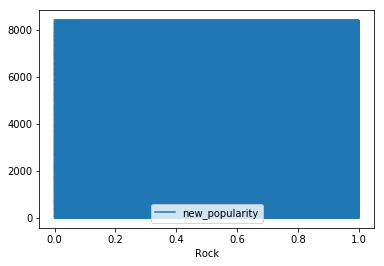

In [112]:
co_ge_me.plot(kind='line', x='Rock', y='new_popularity')


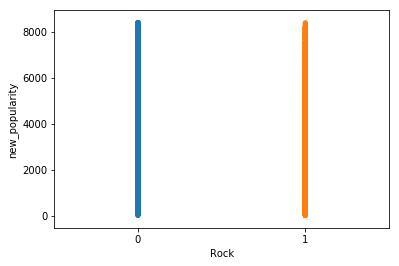

In [115]:
sns.stripplot(x = 'Rock' , y = 'new_popularity' , data = co_ge_me)

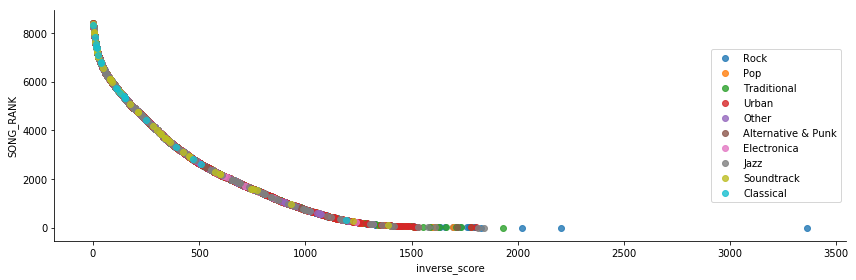

In [139]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="inverse_score", y="SONG_RANK", data=Final_DF, fit_reg=False, hue='genre', legend=False,size=4, aspect=3)
 
# Move the legend to an empty part of the plot
plt.legend(loc='right')
 
#sns.plt.show()

In [128]:
co_ge_me.head()

,song,artist,inverse_score,number_of_weeks,SONG_RANK,genre,lastfm_count,new_popularity,year,Alternative & Punk,Classical,Electronica,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban
5441,Paranoid,Black Sabbath,138,5,5450,Rock,7846242,1,1970,0,0,0,0,0,0,1,0,0,0
511,The Sound Of Silence,Simon & Garfunkel,1092,14,513,Pop,7006004,2,1965,0,0,0,0,0,1,0,0,0,0
860,"Paint It, Black",The Rolling Stones,963,11,862,Pop,6971647,3,1966,0,0,0,0,0,1,0,0,0,0
175,Let It Be,The Beatles,1287,14,176,Rock,6917316,4,1970,0,0,0,0,0,0,1,0,0,0
867,Yesterday,The Beatles,961,11,869,Rock,6647511,5,1965,0,0,0,0,0,0,1,0,0,0


In [129]:
#df2 = pd.merge(co_ge_me,artist,how = 'left' ,on =['song','artist'])

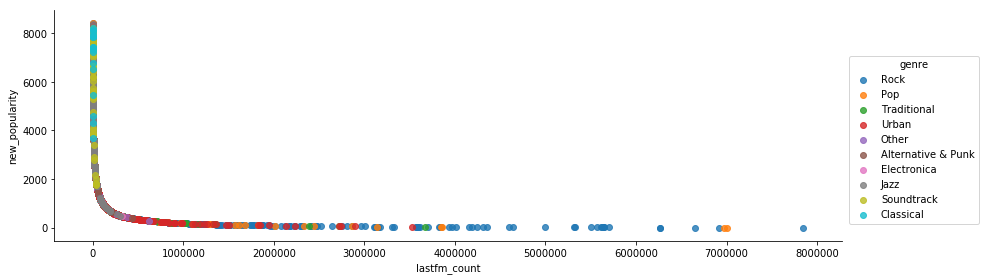

In [148]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="lastfm_count", y="new_popularity", data=Final_DF, fit_reg=False, hue='genre', legend=True,size=4, aspect=3)
 
# Move the legend to an empty part of the plot
#plt.legend(loc='right')
 
#sns.plt.show()

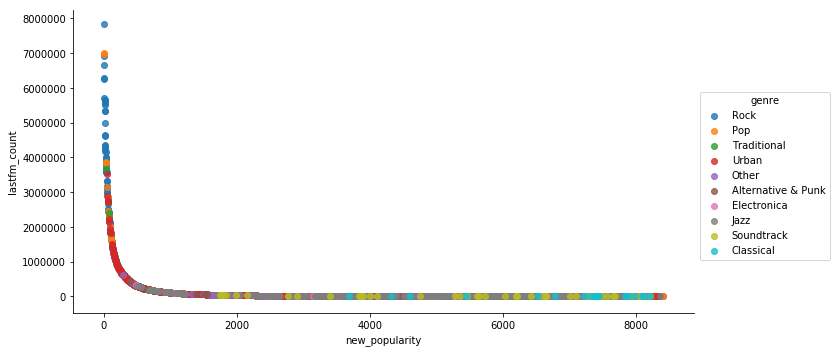

In [151]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="new_popularity", y="lastfm_count", data=Final_DF, fit_reg=False, hue='genre', legend=True,size=5, aspect=2)
 
# Move the legend to an empty part of the plot
#plt.legend(loc='right')
 
#sns.plt.show()

In [153]:
Final_DF.rename(columns={'SONG_RANK' : 'old_popularity'},inplace = True)

In [154]:
co_ge_me.rename(columns={'SONG_RANK' : 'old_popularity'},inplace = True)

In [155]:
co_ge_me.head(20)

,song,artist,inverse_score,number_of_weeks,old_popularity,genre,lastfm_count,new_popularity,year,Alternative & Punk,Classical,Electronica,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban
5441,Paranoid,Black Sabbath,138,5,5450,Rock,7846242,1,1970,0,0,0,0,0,0,1,0,0,0
511,The Sound Of Silence,Simon & Garfunkel,1092,14,513,Pop,7006004,2,1965,0,0,0,0,0,1,0,0,0,0
860,"Paint It, Black",The Rolling Stones,963,11,862,Pop,6971647,3,1966,0,0,0,0,0,1,0,0,0,0
175,Let It Be,The Beatles,1287,14,176,Rock,6917316,4,1970,0,0,0,0,0,0,1,0,0,0
867,Yesterday,The Beatles,961,11,869,Rock,6647511,5,1965,0,0,0,0,0,0,1,0,0,0
3908,Immigrant Song,Led Zeppelin,313,6,3914,Rock,6268358,6,1970,0,0,0,0,0,0,1,0,0,0
406,Help!,The Beatles,1136,13,407,Rock,6265950,7,1965,0,0,0,0,0,0,1,0,0,0
1085,Like A Rolling Stone,Bob Dylan,888,12,1087,Rock,5706300,8,1965,0,0,0,0,0,0,1,0,0,0
286,Whole Lotta Love,Led Zeppelin,1202,15,287,Rock,5650518,9,1969,0,0,0,0,0,0,1,0,0,0
2014,People Are Strange,The Doors,644,9,2017,Rock,5647930,10,1967,0,0,0,0,0,0,1,0,0,0


In [158]:
grammy = pd.read_csv('grammys/data/grammysTo2014.csv',encoding = "ISO-8859-1")

In [159]:
grammy.tail()

,Year,Category,song,Winners
3948,1958,Best Classical Performance - Instrumentalist (...,Tchaikovsky: Piano Concerto No. 1 In B Flat Mi...,"Van Cliburn, artist."
3949,1958,Best Classical Performance - Instrumentalist (...,Segovia Golden Jubilee,"Andres Segovia, artist."
3950,1958,Best Classical Performance - Chamber Music (In...,Beethoven: Quartet 130,"Hollywood String Quartet (Alvin Dinkin, Paul S..."
3951,1958,Best Classical Performance - Vocal Soloist (Wi...,Operatic Recital,"Renata Tebaldi, artist."
3952,1958,Best Classical Performance - Operatic Or Choral,Virtuoso,"Roger Wagner, choir director."


In [162]:
gramy_merge = pd.merge(co_ge_me,grammy,how = 'inner' , on = 'song')

In [163]:
gramy_merge

,song,artist,inverse_score,number_of_weeks,old_popularity,genre,lastfm_count,new_popularity,year,Alternative & Punk,...,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban,Year,Category,Winners
0,Let It Be,The Beatles,1287,14,176,Rock,6917316,4,1970,0,...,0,0,0,1,0,0,0,1970,Best Original Score Written For A Motion Pictu...,"George Harrison, John Lennon,Paul McCartney & ..."
1,Something,The Beatles,549,6,2421,Rock,5623107,11,1969,0,...,0,0,0,1,0,0,0,2013,Best R&B Performance,Lalah Hathaway & Snarky Puppy (Michael League)...
2,Something,Shirley Bassey,287,9,4139,Pop,90908,1107,1970,0,...,0,0,1,0,0,0,0,2013,Best R&B Performance,Lalah Hathaway & Snarky Puppy (Michael League)...
3,Something,Booker T. & The MG's,73,4,6181,Urban,20344,2353,1970,0,...,0,0,0,0,0,0,1,2013,Best R&B Performance,Lalah Hathaway & Snarky Puppy (Michael League)...
4,Eleanor Rigby,The Beatles,576,8,2282,Rock,5617352,12,1966,0,...,0,0,0,1,0,0,0,1966,"Best Contemporary (R&R) Group Performance, Voc...","Paul McCartney, artist."
5,Eleanor Rigby,Aretha Franklin,518,8,2564,Urban,149014,799,1969,0,...,0,0,0,0,0,0,1,1966,"Best Contemporary (R&R) Group Performance, Voc...","Paul McCartney, artist."
6,Eleanor Rigby,Ray Charles,494,10,2692,Urban,91895,1099,1968,0,...,0,0,0,0,0,0,1,1966,"Best Contemporary (R&R) Group Performance, Voc...","Paul McCartney, artist."
7,Light My Fire,The Doors,1442,23,71,Rock,5574004,13,1967,0,...,0,0,0,1,0,0,0,1968,"Best Contemporary Pop Performance, Instrumental","Jose Feliciano, artist."
8,Light My Fire,Jose Feliciano,1013,12,706,NaN,198775,661,1968,0,...,0,0,0,0,0,0,0,1968,"Best Contemporary Pop Performance, Instrumental","Jose Feliciano, artist."
9,Mrs. Robinson,Simon & Garfunkel,1134,13,415,Pop,3853551,28,1968,0,...,0,0,1,0,0,0,0,1968,Record Of The Year,"Simon And Garfunkel* (Art Garfunkel*, Paul Sim..."


In [690]:
gramy_merge[gramy_merge['artist'] == "Elvis Presley"]

,song,artist,inverse_score,number_of_weeks,old_popularity,genre,lastfm_count,new_popularity,year,Alternative & Punk,...,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban,Year,Category,Winners
53,In The Ghetto,Elvis Presley,1053,13,615,Rock,1366175,130,1969,0,...,0,0,0,1,0,0,0,1974,Best Soul Gospel Performance,"James Cleveland, artist."


In [167]:
co_ge_me.reset_index(inplace = True)
co_ge_me.index = co_ge_me.index + 1

In [169]:
co_ge_me.drop("index",axis = 1,inplace = True)

In [172]:
co_ge_me.to_csv("old_genre_new.csv",index = False)

In [177]:
co_ge_me[(co_ge_me.index >=1) & (co_ge_me.index <= 800)]['group'] = 1 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [179]:
co_ge_me['group'] = 0

In [198]:
row = co_ge_me.shape[0]
print(row)
for i in range(1,10):
    print((1+(row/10)*(i-1)),"  ",(row/10)*i)
    co_ge_me['group'].iloc[ (co_ge_me.index >= int((1 + (i-1)*(row/10)))) & (co_ge_me.index <= int((row/10)*i))] = i
print("end")

8396
1.0   

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


 839.6
840.6    1679.2
1680.2    2518.8
2519.8    3358.4
3359.4    4198.0
4199.0    5037.6
5038.6    5877.2
5878.2    6716.8
6717.8    7556.400000000001


NameError: name 'end' is not defined

In [202]:
co_ge_me['group'].iloc[(co_ge_me.index > 7556) & (co_ge_me.index <= 8396)] = 10

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [207]:
co_ge_me['genre'] = co_ge_me['genre'].astype('category')

In [208]:
co_ge_me

,song,artist,inverse_score,number_of_weeks,old_popularity,genre,lastfm_count,new_popularity,year,Alternative & Punk,Classical,Electronica,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban,group
1,Paranoid,Black Sabbath,138,5,5450,Rock,7846242,1,1970,0,0,0,0,0,0,1,0,0,0,1
2,The Sound Of Silence,Simon & Garfunkel,1092,14,513,Pop,7006004,2,1965,0,0,0,0,0,1,0,0,0,0,1
3,"Paint It, Black",The Rolling Stones,963,11,862,Pop,6971647,3,1966,0,0,0,0,0,1,0,0,0,0,1
4,Let It Be,The Beatles,1287,14,176,Rock,6917316,4,1970,0,0,0,0,0,0,1,0,0,0,1
5,Yesterday,The Beatles,961,11,869,Rock,6647511,5,1965,0,0,0,0,0,0,1,0,0,0,1
6,Immigrant Song,Led Zeppelin,313,6,3914,Rock,6268358,6,1970,0,0,0,0,0,0,1,0,0,0,1
7,Help!,The Beatles,1136,13,407,Rock,6265950,7,1965,0,0,0,0,0,0,1,0,0,0,1
8,Like A Rolling Stone,Bob Dylan,888,12,1087,Rock,5706300,8,1965,0,0,0,0,0,0,1,0,0,0,1
9,Whole Lotta Love,Led Zeppelin,1202,15,287,Rock,5650518,9,1969,0,0,0,0,0,0,1,0,0,0,1
10,People Are Strange,The Doors,644,9,2017,Rock,5647930,10,1967,0,0,0,0,0,0,1,0,0,0,1


In [226]:
from sklearn.cross_validation import train_test_split

train_x, test_x, train_y, test_y = train_test_split(co_ge_me[['old_popularity','Classical', 'Electronica', 'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional','Urban']],
    co_ge_me['group'], train_size=0.7)

In [227]:
from sklearn import linear_model
from sklearn import metrics

# Train multi-classification model with logistic regression
lr = linear_model.LogisticRegression()
lr.fit(train_x, train_y)

# Train multinomial logistic regression model
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(train_x, train_y)

print ("Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, lr.predict(train_x)))
print ("Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, lr.predict(test_x)))
    
print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))
 

Logistic regression Train Accuracy ::  0.197719925132
Logistic regression Test Accuracy ::  0.198094481937
Multinomial Logistic regression Train Accuracy ::  0.201463331632
Multinomial Logistic regression Test Accuracy ::  0.195712584359


In [230]:
list(mul_lr.predict(test_x))

[2,
 6,
 7,
 7,
 5,
 9,
 7,
 3,
 7,
 1,
 8,
 2,
 8,
 4,
 8,
 2,
 10,
 8,
 1,
 2,
 3,
 7,
 4,
 5,
 10,
 1,
 9,
 7,
 1,
 5,
 7,
 1,
 1,
 5,
 4,
 10,
 10,
 2,
 1,
 10,
 2,
 3,
 1,
 7,
 7,
 1,
 8,
 8,
 1,
 1,
 4,
 9,
 9,
 4,
 7,
 2,
 2,
 5,
 9,
 1,
 9,
 9,
 9,
 7,
 10,
 1,
 5,
 10,
 9,
 7,
 1,
 2,
 1,
 9,
 4,
 1,
 2,
 7,
 7,
 10,
 8,
 2,
 4,
 2,
 1,
 10,
 10,
 9,
 1,
 7,
 1,
 5,
 2,
 2,
 2,
 9,
 5,
 9,
 9,
 1,
 4,
 3,
 5,
 7,
 2,
 5,
 6,
 1,
 10,
 7,
 4,
 1,
 4,
 10,
 1,
 7,
 9,
 3,
 1,
 5,
 1,
 10,
 8,
 1,
 7,
 4,
 9,
 6,
 9,
 7,
 3,
 2,
 7,
 4,
 10,
 3,
 9,
 10,
 9,
 1,
 1,
 1,
 8,
 5,
 1,
 10,
 1,
 1,
 9,
 1,
 9,
 1,
 9,
 6,
 1,
 6,
 10,
 1,
 9,
 6,
 10,
 1,
 9,
 2,
 1,
 9,
 6,
 1,
 9,
 9,
 7,
 8,
 3,
 1,
 7,
 3,
 8,
 2,
 2,
 1,
 8,
 1,
 1,
 1,
 3,
 1,
 1,
 8,
 9,
 9,
 9,
 2,
 1,
 6,
 7,
 10,
 5,
 8,
 1,
 7,
 1,
 9,
 10,
 6,
 7,
 5,
 7,
 9,
 1,
 1,
 10,
 9,
 2,
 4,
 4,
 1,
 7,
 1,
 3,
 1,
 3,
 2,
 8,
 7,
 10,
 1,
 4,
 1,
 3,
 4,
 6,
 9,
 5,
 7,
 10,
 6,
 10,
 9,
 1,
 10,
 10,
 9,
 9,
 1

In [229]:
test_y

4878     6
2060     3
5217     7
5936     8
5093     7
6928     9
5085     7
5505     7
3781     5
1629     2
5523     7
447      1
5812     7
4111     5
5478     7
1569     2
1272     2
2801     4
304      1
2746     4
1247     2
3108     4
4743     6
426      1
7965    10
1973     3
4849     6
3020     4
8285    10
3703     5
        ..
776      1
710      1
4322     6
6021     8
5616     7
2151     3
4147     5
6131     8
7340     9
2037     3
1928     3
3264     4
895      2
2934     4
4964     6
8219    10
3699     5
1558     2
8151    10
2265     3
1703     3
6666     8
8201    10
4350     6
5751     7
1338     2
87       1
7961    10
5572     7
5424     7
Name: group, Length: 2519, dtype: int64

In [231]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y,mul_lr.predict(test_x))
print(mse)

10.0365224295


In [233]:
test_x.shape

(2519, 10)

In [236]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y,mul_lr.predict(test_x))
confusion_matrix


array([[161,  34,  10,   9,   6,   7,  12,   7,   5,  12],
       [133,  40,  11,  11,  12,  12,  21,  11,  19,  10],
       [ 92,  41,  15,  16,  13,   6,  22,  18,  18,  16],
       [ 76,  28,  16,  16,  15,   7,  41,  20,  26,  13],
       [ 62,  16,  14,  21,  13,  11,  33,  17,  34,  20],
       [ 45,  19,  22,  24,  13,  17,  54,  22,  32,  18],
       [ 30,  13,   9,  21,  10,  14,  43,  33,  40,  27],
       [ 20,   8,  11,  20,   6,   5,  53,  36,  56,  28],
       [ 15,   5,   6,  11,   9,   8,  41,  30,  80,  38],
       [ 16,   6,   6,   6,   6,   8,  25,  23,  60,  72]])

In [240]:
from sklearn.cross_validation import train_test_split

train_x, test_x, train_y, test_y = train_test_split(co_ge_me[['old_popularity','Classical','Electronica', 'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional','Urban',"Alternative & Punk"]],
    co_ge_me['group'], train_size=0.7)


from sklearn import linear_model
from sklearn import metrics

# Train multi-classification model with logistic regression
lr = linear_model.LogisticRegression()
lr.fit(train_x, train_y)

# Train multinomial logistic regression model
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(train_x, train_y)

print ("Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, lr.predict(train_x)))
print ("Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, lr.predict(test_x)))
    
print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))
 
    
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y,mul_lr.predict(test_x))
print("MSE :  ", mse)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y,mul_lr.predict(test_x))
print(confusion_matrix)


Logistic regression Train Accuracy ::  0.194827292836
Logistic regression Test Accuracy ::  0.203255260024
Multinomial Logistic regression Train Accuracy ::  0.192445125064
Multinomial Logistic regression Test Accuracy ::  0.205637157602
MSE :   9.99444223898
[[147  46   0  24   7   9  11   2   8  10]
 [ 87  60   1  29   6  12  13  15  21  13]
 [ 66  58   3  40  11  18  17   7  21  11]
 [ 66  31   1  33   6  10   9  11  28  17]
 [ 56  25   0  39   6  11  23  29  34  22]
 [ 39  31   2  34   4  27  22  27  43  25]
 [ 28  12   3  41   9  23  31  42  51  30]
 [ 20  14   1  25   5  24  36  34  59  35]
 [  7  15   1  26   7  12  29  30  87  51]
 [ 13   9   1  16   6  12  18  22  60  90]]


/usr/local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:421: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Text(0.5,0,'predicted label')

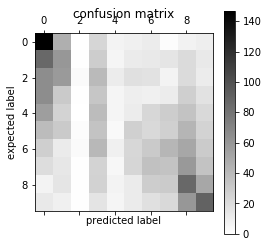

In [243]:
plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [258]:
 from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf = clf.fit(train_x, train_y)

metrics.accuracy_score(test_y, clf.predict(test_x))

0.14767764986105597

4671    False
4468    False
1522    False
4240    False
7338    False
5036     True
5753    False
3724    False
4951    False
7172    False
580      True
5344    False
647     False
5521    False
466     False
5178    False
4396    False
3299    False
6564    False
6867    False
6744    False
1601    False
6989    False
3502    False
6651    False
4935     True
1720    False
7872    False
6259     True
3898    False
        ...  
2944    False
6135    False
7370     True
2689    False
362     False
369     False
5622     True
3356    False
643      True
5286    False
582      True
4563    False
2754    False
2188    False
1453    False
1959    False
1371    False
3100     True
1326    False
619     False
156     False
1682    False
6832    False
5650    False
605      True
4463    False
218     False
6140     True
7968    False
4906    False
Name: group, Length: 2519, dtype: bool

In [259]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y,clf.predict(test_x))
print(mse)

11.3290988487


# From here , just add up the whatever features you think are good and run the functions "AS IT IS", We will know what we are doing better ,The below functions are separately for all machine learning algo.There is one big function at the end which compares all the machine learning algos and itself splits the data.
https://machinelearningmastery.com/get-your-hands-dirty-with-scikit-learn-now/


In [ ]:
from sklearn.cross_validation import train_test_split

train_x, test_x, train_y, test_y = train_test_split(co_ge_me[['old_popularity','Classical','Electronica', 'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional','Urban',"Alternative & Punk"]],
    co_ge_me['group'], train_size=0.7)

In [263]:
# Logistic Regression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
# load the iris datasets

# fit a logistic regression model to the data
model = LogisticRegression()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(mean_squared_error(expected,predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.27      0.53      0.35       264
          2       0.24      0.25      0.24       257
          3       0.00      0.00      0.00       252
          4       0.13      0.13      0.13       212
          5       0.08      0.04      0.05       245
          6       0.16      0.11      0.13       254
          7       0.18      0.10      0.12       270
          8       0.14      0.20      0.17       253
          9       0.20      0.15      0.18       265
         10       0.25      0.50      0.33       247

avg / total       0.17      0.20      0.17      2519

[[140  53   0  19   8  14   2  10   6  12]
 [ 82  64   2  19   8  13  13  23  13  20]
 [ 64  53 

In [264]:
# Naive Bayes
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
model = GaussianNB()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(mean_squared_error(expected,predicted))

GaussianNB(priors=None)
             precision    recall  f1-score   support

          1       0.21      0.70      0.32       264
          2       0.13      0.20      0.16       257
          3       0.00      0.00      0.00       252
          4       0.18      0.01      0.02       212
          5       0.23      0.01      0.02       245
          6       0.11      0.43      0.18       254
          7       0.00      0.00      0.00       270
          8       0.00      0.00      0.00       253
          9       0.23      0.08      0.12       265
         10       0.19      0.09      0.12       247

avg / total       0.13      0.16      0.10      2519

[[184  45   0   1   1  28   0   2   2   1]
 [131  52   0   1   1  62   0   1   4   5]
 [111  67   0   3   2  58   0   0   5   6]
 [ 88  50   0   2   0  63   0   1   4   4]
 [ 81  37   0   0   3 102   0   1  13   8]
 [ 83  42   1   1   1 108   0   2   7   9]
 [ 61  33   2   0   5 141   0   3  12  13]
 [ 59  27   2   1   0 128   0   0  1

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [265]:
# knn
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
model = KNeighborsClassifier()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(mean_squared_error(expected,predicted))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
             precision    recall  f1-score   support

          1       0.19      0.37      0.25       264
          2       0.15      0.20      0.17       257
          3       0.12      0.13      0.13       252
          4       0.09      0.10      0.10       212
          5       0.13      0.10      0.11       245
          6       0.16      0.12      0.14       254
          7       0.15      0.11      0.12       270
          8       0.15      0.12      0.14       253
          9       0.14      0.11      0.12       265
         10       0.14      0.11      0.12       247

avg / total       0.14      0.15      0.14      2519

[[97 57 32 16 18 13  8  7 10  6]
 [77 51 30 22 13 17  8 10 13 16]
 [70 36 33 22 24 19 10 13 10 15]
 [45 27 28 22 16 18 14 13 15 14]
 [43 32 22 27 24 20 28 14 24 11]
 [34 31 28 34 23 31 18 21 22 12]

In [266]:
# DEcision Tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
model = DecisionTreeClassifier()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(mean_squared_error(expected,predicted))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
             precision    recall  f1-score   support

          1       0.26      0.25      0.26       264
          2       0.14      0.12      0.13       257
          3       0.14      0.13      0.14       252
          4       0.10      0.13      0.11       212
          5       0.08      0.07      0.08       245
          6       0.12      0.13      0.13       254
          7       0.14      0.11      0.13       270
          8       0.17      0.16      0.16       253
          9       0.13      0.13      0.13       265
         10       0.23      0.25      0.24       247

avg / total       0.15      0.15      0.15      2519

[[67 41 44 

In [267]:
# DEcision Tree
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
model = SVC()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print(mean_squared_error(expected,predicted))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          1       0.26      0.22      0.24       264
          2       0.20      0.16      0.18       257
          3       0.15      0.14      0.14       252
          4       0.11      0.17      0.13       212
          5       0.09      0.10      0.09       245
          6       0.13      0.13      0.13       254
          7       0.14      0.11      0.13       270
          8       0.15      0.14      0.14       253
          9       0.15      0.14      0.14       265
         10       0.14      0.17      0.15       247

avg / total       0.15      0.15      0.15      2519

[[58 50 40 31 23 13  9 15 14 11]
 [33 42 28 30 25 24 19 12 18 26]
 [36 25 35 28 30 24 11 17 10 36]
 [21 15 22 35 28 22 16 17 11 25]
 [18

# This Function below takes in the whole dataset which you want to learn.It splits and applys below models.Please Dig some more information by adding some more features
Add the features in the dataset and then add that columnn in the X given below.
I think by adding like this one by one we will some how reach a better model.
"Its all about what featires we select."

https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

Refer these links if anything.And Lets chat by mail.
Please revert back to me for any queries.

LR: 0.000476 (0.000584)
LDA: 0.005837 (0.011069)
KNN: 0.000119 (0.000357)
CART: 0.000596 (0.000596)
NB: 0.108146 (0.126475)
SVM: 0.000238 (0.000476)


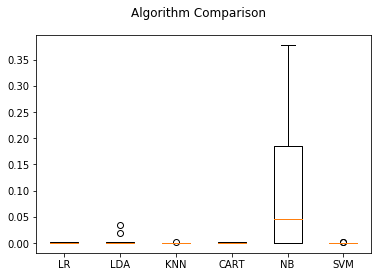

In [293]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
"""
# load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
"""
X = co_ge_me[['old_popularity','Classical','Electronica', 'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional','Urban',"Alternative & Punk",'year']]
Y = co_ge_me['group']
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [465]:
df = hot5870.copy()
for index, row in df.iterrows():
    if " with " in row['artist']:
        df['artist'][index] = row['artist'].split(" with ")[0]
    if " With " in row['artist']:
        df['artist'][index] = row['artist'].split(" With ")[0]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [467]:
artist_songs_count = df.groupby('artist').count().reset_index()

In [468]:
artist_songs_count.drop(['date','inverse_score'],axis = 1,inplace = True)
artist_songs_count.rename(columns={'song' : 'number_of_songs_by_artist'},inplace = True)

In [469]:
artist_songs_count.sort_values('number_of_songs_by_artist',ascending=False,inplace = True)

In [470]:
artist_songs_count.reset_index(inplace = True)
artist_songs_count.index = artist_songs_count.index + 1

In [473]:
artist_songs_count.drop('index',axis = 1,inplace = True)

In [474]:
artist_songs_count.head()

,artist,number_of_songs_by_artist
1,Elvis Presley,742
2,The Beatles,530
3,Connie Francis,485
4,Brenda Lee,412
5,Brook Benton,365


In [308]:
artist_songs_count['artist_rank'] = artist_songs_count.index

In [386]:
artist_songs_count[artist_songs_count['artist'].str.contains("Melanie")]

,artist,number_of_songs_by_artist,artist_rank
903,Melanie with The Edwin Hawkins Singers,17,903
1265,Melanie,11,1265


In [310]:
co_ge_ar = pd.merge(co_ge_me,artist_songs_count, how = 'inner' , on = 'artist')

In [311]:
co_ge_ar.head()

,song,artist,inverse_score,number_of_weeks,old_popularity,genre,lastfm_count,new_popularity,year,Alternative & Punk,...,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban,group,number_of_songs_by_artist,artist_rank
0,Paranoid,Black Sabbath,138,5,5450,Rock,7846242,1,1970,0,...,0,0,0,1,0,0,0,1,5,1802
1,The Sound Of Silence,Simon & Garfunkel,1092,14,513,Pop,7006004,2,1965,0,...,0,0,1,0,0,0,0,1,142,89
2,Mrs. Robinson,Simon & Garfunkel,1134,13,415,Pop,3853551,28,1968,0,...,0,0,1,0,0,0,0,1,142,89
3,The Boxer,Simon & Garfunkel,832,10,1305,Pop,2864595,54,1969,0,...,0,0,1,0,0,0,0,1,142,89
4,Bridge Over Troubled Water,Simon & Garfunkel,1288,14,175,Pop,2440266,68,1970,0,...,0,0,1,0,0,0,0,1,142,89


LR: 0.110272 (0.046748)
LDA: 0.116229 (0.045494)


/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


KNN: 0.104429 (0.052006)
CART: 0.115634 (0.030863)
NB: 0.123851 (0.049627)
SVM: 0.009167 (0.013374)


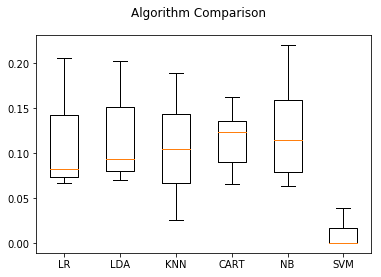

In [330]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
"""
# load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
"""
"""
Index(['song', 'artist', 'inverse_score', 'number_of_weeks', 'old_popularity',
       'genre', 'lastfm_count', 'new_popularity', 'year', 'Alternative & Punk',
       'Classical', 'Electronica', 'Jazz', 'Other', 'Pop', 'Rock',
       'Soundtrack', 'Traditional', 'Urban', 'group',
       'number_of_songs_by_artist', 'artist_rank','genre_category'],
      dtype='object')
"""

X = co_ge_ar[['artist_rank','old_popularity','number_of_weeks','genre_category']]
Y = co_ge_ar['group']
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [336]:
-

BEGIN
*****************************************LR***************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.20      0.70      0.31       209
          2       0.03      0.01      0.01       226
          3       0.08      0.00      0.01       221
          4       0.25      0.01      0.03       219
          5       0.13      0.17      0.15       202
          6       0.17      0.07      0.10       231
          7       0.13      0.18      0.15       188
          8       0.10      0.10      0.10       202
          9       0.19      0.07      0.10       211
         10       0.20      0.38      0.26       190

avg / total       0.15      0.17      0.12      2099

[[147  

In [327]:
co_ge_ar['genre_category'] = co_ge_ar['genre'].astype('category').cat.codes

In [329]:
co_ge_ar.head()

,song,artist,inverse_score,number_of_weeks,old_popularity,genre,lastfm_count,new_popularity,year,Alternative & Punk,...,Other,Pop,Rock,Soundtrack,Traditional,Urban,group,number_of_songs_by_artist,artist_rank,genre_category
0,Paranoid,Black Sabbath,138,5,5450,Rock,7846242,1,1970,0,...,0,0,1,0,0,0,1,5,1802,6
1,The Sound Of Silence,Simon & Garfunkel,1092,14,513,Pop,7006004,2,1965,0,...,0,1,0,0,0,0,1,142,89,5
2,Mrs. Robinson,Simon & Garfunkel,1134,13,415,Pop,3853551,28,1968,0,...,0,1,0,0,0,0,1,142,89,5
3,The Boxer,Simon & Garfunkel,832,10,1305,Pop,2864595,54,1969,0,...,0,1,0,0,0,0,1,142,89,5
4,Bridge Over Troubled Water,Simon & Garfunkel,1288,14,175,Pop,2440266,68,1970,0,...,0,1,0,0,0,0,1,142,89,5


In [337]:
result

,expected,LR,NB,KNN,DT,SVC
5839,6,9,5,10,10,7
2118,9,6,5,2,8,7
7916,9,10,10,8,7,7
8105,10,10,10,8,10,7
75,1,6,6,3,10,7
4309,4,10,9,2,3,7
3684,2,3,1,7,8,7
6396,10,8,8,8,9,7
5303,8,8,9,1,7,7
2027,1,1,1,4,2,7


In [357]:
youtube= pd.read_csv('youtube_count.atsv',sep = '@')

In [359]:
youtube

,song,artist,youtube
0,The Twist,Chubby Checker,4227828.0
1,Wipe Out,The Surfaris,6540784.0
2,Harlem Nocturne,The Viscounts,521859.0
3,The Little Drummer Boy,The Harry Simeone Chorale,115716.0
4,Running Bear,Johnny Preston,1512093.0
5,Sunshine Of Your Love,Cream,10499945.0
6,Moon River,Henry Mancini And His Orchestra,243313.0
7,Never On Sunday,Don Costa And His Orchestra And Chorus,24256.0
8,Finger Poppin' Time,Hank Ballard And The Midnighters,127623.0
9,Robbin' The Cradle,Tony Bellus,22256.0


In [360]:
co_ge_ar_yu = pd.merge(co_ge_ar,youtube,how = 'inner' , on = ['song','artist'])

In [361]:
co_ge_ar_yu

,song,artist,inverse_score,number_of_weeks,old_popularity,genre,lastfm_count,new_popularity,year,Alternative & Punk,...,Pop,Rock,Soundtrack,Traditional,Urban,group,number_of_songs_by_artist,artist_rank,genre_category,youtube
0,Paranoid,Black Sabbath,138,5,5450,Rock,7846242,1,1970,0,...,0,1,0,0,0,1,5,1802,6,34248.0
1,The Sound Of Silence,Simon & Garfunkel,1092,14,513,Pop,7006004,2,1965,0,...,1,0,0,0,0,1,142,89,5,162078354.0
2,Mrs. Robinson,Simon & Garfunkel,1134,13,415,Pop,3853551,28,1968,0,...,1,0,0,0,0,1,142,89,5,35248644.0
3,The Boxer,Simon & Garfunkel,832,10,1305,Pop,2864595,54,1969,0,...,1,0,0,0,0,1,142,89,5,20520509.0
4,Bridge Over Troubled Water,Simon & Garfunkel,1288,14,175,Pop,2440266,68,1970,0,...,1,0,0,0,0,1,142,89,5,20479421.0
5,Cecilia,Simon & Garfunkel,1047,13,626,Pop,2334455,72,1970,0,...,1,0,0,0,0,1,142,89,5,18053989.0
6,I Am A Rock,Simon & Garfunkel,928,11,963,Pop,1820158,100,1966,0,...,1,0,0,0,0,1,142,89,5,5400789.0
7,Homeward Bound,Simon & Garfunkel,909,12,1016,Pop,1676501,108,1966,0,...,1,0,0,0,0,1,142,89,5,5833630.0
8,El Condor Pasa (If I Could),Simon & Garfunkel,757,11,1569,Pop,1294854,139,1970,0,...,1,0,0,0,0,1,142,89,5,1448202.0
9,A Hazy Shade Of Winter,Simon & Garfunkel,625,9,2084,Pop,996894,179,1966,0,...,1,0,0,0,0,1,142,89,5,1882646.0


In [365]:
co_ge_ar_yu['new_total_count'] = co_ge_ar_yu['lastfm_count'] + co_ge_ar_yu['youtube']

In [367]:
rank_by_youtube = co_ge_ar_yu.sort_values('youtube',ascending=False)

In [370]:
rank_by_youtube.reset_index(inplace = True)

In [371]:
rank_by_youtube.index = rank_by_youtube.index + 1

In [375]:
rank_by_youtube[rank_by_youtube['song'] == "Don't Let Me Down"]

,index,song,artist,inverse_score,number_of_weeks,old_popularity,genre,lastfm_count,new_popularity,year,...,Rock,Soundtrack,Traditional,Urban,group,number_of_songs_by_artist,artist_rank,genre_category,youtube,new_total_count
6,151,Don't Let Me Down,The Beatles With Billy Preston,251,4,4422,Rock,1982612,89,1969,...,1,0,0,0,1,16,932,6,103771867.0,105754479.0


In [377]:
rank_by_youtube['youtube_rank'] = rank_by_youtube.index

In [389]:
youtube.isnull().sum()

song        0
artist     14
youtube    14
dtype: int64

In [390]:
rank_by_youtube[rank_by_youtube['artist'].str.contains("Melanie")]

,index,song,artist,inverse_score,number_of_weeks,old_popularity,genre,lastfm_count,new_popularity,year,...,Soundtrack,Traditional,Urban,group,number_of_songs_by_artist,artist_rank,genre_category,youtube,new_total_count,youtube_rank
936,3033,Ruby Tuesday,Melanie,120,4,5637,Pop,180751,712,1970,...,0,0,0,1,11,1265,5,925516.0,1106267.0,936
2173,6448,Lay Down (Candles In The Rain),Melanie with The Edwin Hawkins Singers,1257,17,207,Pop,4342,3965,1970,...,0,0,0,5,17,903,5,186484.0,190826.0,2173
2889,3034,Peace Will Come (According To Plan),Melanie,426,7,3098,Pop,15973,2598,1970,...,0,0,0,4,11,1265,5,95734.0,111707.0,2889


In [393]:
rank_by_youtube.drop('index',axis = 1,inplace = True)

In [395]:
rank_by_youtube.rename(columns = {'new_popularity' : 'lastfm_rank','lastfm_count' : 'lastfm'},inplace = True)

In [396]:
rank_by_youtube.head()

,song,artist,inverse_score,number_of_weeks,old_popularity,genre,lastfm,lastfm_rank,year,Alternative & Punk,...,Soundtrack,Traditional,Urban,group,number_of_songs_by_artist,artist_rank,genre_category,youtube,new_total_count,youtube_rank
1,The House Of The Rising Sun,The Animals,963,11,863,Rock,4600463,19,1964,0,...,0,0,0,1,86,181,6,194167598.0,198768061.0,1
2,The Sound Of Silence,Simon & Garfunkel,1092,14,513,Pop,7006004,2,1965,0,...,0,0,0,1,142,89,5,162078354.0,169084358.0,2
3,California Dreamin',The Mamas & The Papas,1265,17,195,Pop,3842033,30,1966,0,...,0,0,0,1,118,119,5,161074487.0,164916520.0,3
4,Stand By Me,Ben E. King,1061,14,591,Urban,2744255,58,1961,0,...,0,0,1,1,124,111,9,140751879.0,143496134.0,4
5,These Boots Are Made For Walkin',Nancy Sinatra,1157,14,364,Rock,803381,220,1966,0,...,0,0,0,1,99,146,6,111380905.0,112184286.0,5


In [400]:
with_copy = artist_songs_count.copy()

In [413]:
with_copy.loc[with_copy['artist'].str.contains(" with ",case = False),'artist'] =   
with_copy.loc[with_copy['artist'].str.lower().split(' with ')
                                                                                                 

3                      Elvis Presley With The Jordanaires
241                           Annette With The Afterbeats
284                      Billy J. Kramer With The Dakotas
483                        Kathy Young with The Innocents
706                         Jerry Wallace With The Jewels
712                      The Chipmunks With David Seville
722                       Safaris with The Phantom's Band
740                          Thomas Wayne With the Delons
781                      Ron Holden with The Thunderbirds
826                      Phil Phillips With The Twilights
830                 Aretha Franklin with The Dixie Flyers
844                           Inez Foxx with Charlie Foxx
903                Melanie with The Edwin Hawkins Singers
932                        The Beatles With Billy Preston
1046    Mitch Miller and his Sing Along With Mitch Chorus
1047                   Buddy Knox with the Rhythm Orchids
1118                     Elvis Presley With The Mello Men
1120          

In [417]:
rank_by_youtube.columns

Index(['song', 'artist', 'inverse_score', 'number_of_weeks', 'old_popularity',
       'genre', 'lastfm', 'lastfm_rank', 'year', 'Alternative & Punk',
       'Classical', 'Electronica', 'Jazz', 'Other', 'Pop', 'Rock',
       'Soundtrack', 'Traditional', 'Urban', 'group',
       'number_of_songs_by_artist', 'artist_rank', 'genre_category', 'youtube',
       'new_total_count', 'youtube_rank'],
      dtype='object')

In [427]:
rank_by_youtube.rename(columns = {'group' : 'groupby_lastfm'},inplace = True)

In [428]:
rank_by_youtube

,groupby_lastfm,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,number_of_songs_by_artist,artist_rank,...,Alternative & Punk,Classical,Electronica,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban
1,1,1964,The House Of The Rising Sun,The Animals,Rock,963,11,863,86,181,...,0,0,0,0,0,0,1,0,0,0
2,1,1965,The Sound Of Silence,Simon & Garfunkel,Pop,1092,14,513,142,89,...,0,0,0,0,0,1,0,0,0,0
3,1,1966,California Dreamin',The Mamas & The Papas,Pop,1265,17,195,118,119,...,0,0,0,0,0,1,0,0,0,0
4,1,1961,Stand By Me,Ben E. King,Urban,1061,14,591,124,111,...,0,0,0,0,0,0,0,0,0,1
5,1,1966,These Boots Are Made For Walkin',Nancy Sinatra,Rock,1157,14,364,99,146,...,0,0,0,0,0,0,1,0,0,0
6,1,1969,Don't Let Me Down,The Beatles With Billy Preston,Rock,251,4,4422,16,932,...,0,0,0,0,0,0,1,0,0,0
7,10,1960,I Need You Now,100 Strings and Jono (Choir of 40 Voices),NaN,3,1,8214,1,2367,...,0,0,0,0,0,0,0,0,0,0
8,10,1965,4 - By The Beatles,The Beatles,Rock,136,5,5478,507,1,...,0,0,0,0,0,0,1,0,0,0
9,1,1968,Hey Jude,The Beatles,Rock,1770,19,14,507,1,...,0,0,0,0,0,0,1,0,0,0
10,1,1967,A Whiter Shade Of Pale,Procol Harum,Rock,977,12,824,17,877,...,0,0,0,0,0,0,1,0,0,0


In [454]:
columnTitles = ['groupby_lastfm','groupby_youtube','year','song', 'artist','genre', 
                'inverse_score', 'number_of_weeks', 'old_popularity','number_of_songs_by_artist','artist_rank',
                'lastfm', 'lastfm_rank', 'youtube','youtube_rank','new_total_count',
                'genre_category', 'Alternative & Punk','Classical', 'Electronica', 'Jazz', 'Other', 'Pop', 'Rock','Soundtrack', 'Traditional', 'Urban' ]

In [455]:
rank_by_youtube = rank_by_youtube.reindex(columns=columnTitles)

In [424]:
rank_by_youtube.to_csv("WorkingDF.csv",index = False)

In [438]:
rank_by_youtube['groupby_youtube'] = 10
row = rank_by_youtube.shape[0]
print(row)
for i in range(1,10):
    print((1+(row/10)*(i-1)),"  ",(row/10)*i)
    rank_by_youtube['groupby_youtube'].iloc[ (rank_by_youtube.index >= int((1 + (i-1)*(row/10)))) & (rank_by_youtube.index <= int((row/10)*i))] = i
print("end")

8392
1.0    839.2


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


840.2    1678.4
1679.4    2517.6000000000004
2518.6000000000004    3356.8
3357.8    4196.0
4197.0    5035.200000000001
5036.200000000001    5874.400000000001
5875.400000000001    6713.6
6714.6    7552.8
end


In [450]:
rank_by_youtube = pd.merge(rank_by_youtube,year,how='inner',on = ['song','artist'])

In [446]:
rank_by_youtube.drop('year_x',axis =1 ,inplace = True)

In [452]:
rank_by_youtube.rename(columns = {'year_y' : 'year'},inplace = True)

In [458]:
rank_by_youtube.columns

Index(['groupby_lastfm', 'groupby_youtube', 'year', 'song', 'artist', 'genre',
       'inverse_score', 'number_of_weeks', 'old_popularity',
       'number_of_songs_by_artist', 'artist_rank', 'lastfm', 'lastfm_rank',
       'youtube', 'youtube_rank', 'new_total_count', 'genre_category',
       'Alternative & Punk', 'Classical', 'Electronica', 'Jazz', 'Other',
       'Pop', 'Rock', 'Soundtrack', 'Traditional', 'Urban'],
      dtype='object')

In [457]:
rank_by_youtube.to_csv("WorkingDF.csv",index = False)

In [486]:
print("BEGIN")



"""
Index(['groupby_lastfm', 'groupby_youtube', 'year', 'song', 'artist', 'genre',
       'inverse_score', 'number_of_weeks', 'old_popularity',
       'number_of_songs_by_artist', 'artist_rank', 'lastfm', 'lastfm_rank',
       'youtube', 'youtube_rank', 'new_total_count', 'genre_category',
       'Alternative & Punk', 'Classical', 'Electronica', 'Jazz', 'Other',
       'Pop', 'Rock', 'Soundtrack', 'Traditional', 'Urban'],
      dtype='object')
"""
from sklearn.cross_validation import train_test_split

train_x, test_x, train_y, test_y = train_test_split(rank_by_youtube[['artist_rank','old_popularity','genre_category']],
    rank_by_youtube['groupby_youtube'], train_size=0.75)

print("*****************************************LR***************************************")

# Logistic Regression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
result =  pd.DataFrame()
# fit a logistic regression model to the data
model = LogisticRegression()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted, normalize=False))
result['expected'] = expected
result['LR'] = predicted
print("*****************************************NB***************************************")

# Naive Bayes
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
model = GaussianNB()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
result['NB'] = predicted
print("*****************************************KNN***************************************")

# knn
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
model = KNeighborsClassifier()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
result['KNN'] = predicted
print("*****************************************DEcision Tree***************************************")

# DEcision Tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
model = DecisionTreeClassifier()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted,normalize=False))
result['DT'] = predicted
print("*****************************************SVM***************************************")

# SVM
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
model = SVC()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted,normalize=False))
result['SVC'] = predicted
print("END")

BEGIN
*****************************************LR***************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.27      0.68      0.39       195
          2       0.12      0.05      0.07       232
          3       0.10      0.05      0.07       212
          4       0.12      0.12      0.12       215
          5       0.11      0.08      0.09       211
          6       0.11      0.06      0.08       208
          7       0.16      0.05      0.07       185
          8       0.13      0.17      0.15       196
          9       0.16      0.09      0.11       211
         10       0.18      0.42      0.25       202

avg / total       0.15      0.17      0.14      2067

[[133  

In [461]:
with_copy = rank_by_youtube.copy()

In [463]:
for index, row in with_copy.iterrows():
    #print index
    #pdb.set_trace()
    #print row['artist']
    if " with " in row['artist']:
        #print (row['artist'])
        with_copy['artist'][index] = row['artist'].split(" with ")[0]
    if " With " in row['artist']:
       # print row['artist']
        #print df[index]['artist']
        with_copy['artist'][index] = row['artist'].split(" With ")[0]
    #print df.loc[index,'artist']

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [464]:
with_copy[with_copy['song'] == "Don't Let Me Down"]

,groupby_lastfm,groupby_youtube,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,number_of_songs_by_artist,...,Alternative & Punk,Classical,Electronica,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban
5,1,1,1969,Don't Let Me Down,The Beatles,Rock,251,4,4422,16,...,0,0,0,0,0,0,1,0,0,0


In [475]:
rank_by_youtube.drop('number_of_songs_by_artist',axis = 1,inplace = True)

In [476]:
rank_by_youtube = pd.merge(rank_by_youtube,artist_songs_count, how = 'inner' , on = 'artist')

In [483]:
rank_by_youtube.sort_values('number_of_songs_by_artist',ascending = False)

,groupby_lastfm,groupby_youtube,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,artist_rank,...,Classical,Electronica,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban,number_of_songs_by_artist
264,1,2,1961,(Marie's The Name) His Latest Flame,Elvis Presley,Rock,755,11,1578,25,...,0,0,0,0,0,1,0,0,0,742
266,5,2,1969,Clean Up Your Own Back Yard,Elvis Presley,Rock,407,8,3213,25,...,0,0,0,0,0,1,0,0,0,742
268,3,3,1964,Ain't That Loving You Baby,Elvis Presley,Rock,691,10,1823,25,...,0,0,0,0,0,1,0,0,0,742
269,10,3,1970,The Wonder Of You/Mama Liked The Roses,Elvis Presley,Rock,937,12,936,25,...,0,0,0,0,0,0,0,0,0,742
270,4,3,1966,Frankie And Johnny,Elvis Presley,Rock,476,8,2789,25,...,0,0,0,0,0,1,0,0,0,742
271,1,3,1968,Guitar Man,Elvis Presley,Rock,276,6,4228,25,...,0,0,0,0,0,1,0,0,0,742
272,10,3,1970,You Don't Have To Say You Love Me/Patch It Up,Elvis Presley,Rock,715,10,1720,25,...,0,0,0,0,0,0,0,0,0,742
273,2,4,1967,Big Boss Man,Elvis Presley,Rock,308,6,3956,25,...,0,0,0,0,0,1,0,0,0,742
274,2,4,1958,I Got Stung,Elvis Presley,Rock,1165,16,353,25,...,0,0,0,0,0,1,0,0,0,742
275,2,4,1961,I Feel So Bad,Elvis Presley,Rock,678,9,1883,25,...,0,0,0,0,0,1,0,0,0,742


In [482]:
rank_by_youtube['genre'] = rank_by_youtube['genre'].fillna('Rock')

In [484]:
rank_by_youtube.head(22)

,groupby_lastfm,groupby_youtube,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,artist_rank,...,Classical,Electronica,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban,number_of_songs_by_artist
0,1,1,1964,The House Of The Rising Sun,The Animals,Rock,963,11,863,181,...,0,0,0,0,0,1,0,0,0,86
1,1,1,1965,We Gotta Get Out Of This Place,The Animals,Rock,746,11,1610,181,...,0,0,0,0,0,1,0,0,0,86
2,1,1,1965,Don't Let Me Be Misunderstood,The Animals,Rock,594,10,2212,181,...,0,0,0,0,0,1,0,0,0,86
3,2,1,1966,Don't Bring Me Down,The Animals,Rock,725,10,1688,181,...,0,0,0,0,0,1,0,0,0,86
4,3,1,1966,Inside-Looking Out,The Animals,Rock,318,7,3879,181,...,0,0,0,0,0,1,0,0,0,86
5,1,2,1965,It's My Life,The Animals,Rock,721,12,1701,181,...,0,0,0,0,0,1,0,0,0,86
6,1,2,1964,Boom Boom,The Animals,Rock,287,7,4140,181,...,0,0,0,0,0,1,0,0,0,86
7,1,4,1965,Bring It On Home To Me,The Animals,Rock,339,6,3682,181,...,0,0,0,0,0,1,0,0,0,86
8,1,4,1964,I'm Crying,The Animals,Rock,567,9,2323,181,...,0,0,0,0,0,1,0,0,0,86
9,9,5,1964,Gonna Send You Back To Walker (Gonna Send You ...,The Animals,Rock,109,3,5752,181,...,0,0,0,0,0,1,0,0,0,86


In [487]:
result.shape

(2067, 6)

In [488]:
df = hot.copy()
for index, row in df.iterrows():
    if " with " in row['artist']:
        df['artist'][index] = row['artist'].split(" with ")[0]
    if " With " in row['artist']:
        df['artist'][index] = row['artist'].split(" With ")[0]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [489]:
full_artist_songs_count = df.groupby('artist').count().reset_index()
"""
full_artist_songs_count.drop(['date','position'],axis = 1,inplace = True)
artist_songs_count.rename(columns={'song' : 'total_number_of_songs_by_artist'},inplace = True)

artist_songs_count.sort_values('total_number_of_songs_by_artist',ascending=False,inplace = True)

artist_songs_count.reset_index(inplace = True)
artist_songs_count.index = artist_songs_count.index + 1

artist_songs_count.drop('index',axis = 1,inplace = True)

artist_songs_count.head()

artist_songs_count['artist_rank'] = artist_songs_count.index



artist_songs_count[artist_songs_count['artist'].str.contains("Melanie")]

"""

'\nfull_artist_songs_count.drop([\'date\',\'inverse_score\'],axis = 1,inplace = True)\nartist_songs_count.rename(columns={\'song\' : \'number_of_songs_by_artist\'},inplace = True)\n\nartist_songs_count.sort_values(\'number_of_songs_by_artist\',ascending=False,inplace = True)\n\nartist_songs_count.reset_index(inplace = True)\nartist_songs_count.index = artist_songs_count.index + 1\n\nartist_songs_count.drop(\'index\',axis = 1,inplace = True)\n\nartist_songs_count.head()\n\nartist_songs_count[\'artist_rank\'] = artist_songs_count.index\n\n\n\nartist_songs_count[artist_songs_count[\'artist\'].str.contains("Melanie")]\n\n'

In [491]:
full_artist_songs_count.drop(['date','position'],axis = 1,inplace = True)
full_artist_songs_count.rename(columns={'song' : 'total_number_of_songs_by_artist'},inplace = True)

full_artist_songs_count.sort_values('total_number_of_songs_by_artist',ascending=False,inplace = True)

full_artist_songs_count.reset_index(inplace = True)
full_artist_songs_count.index = full_artist_songs_count.index + 1

In [493]:
full_artist_songs_count.drop('index',axis = 1,inplace = True)

In [495]:
co_ge_full_ar = pd.merge(rank_by_youtube,full_artist_songs_count,how = 'inner',on = 'artist')

In [496]:
co_ge_full_ar.head()

,groupby_lastfm,groupby_youtube,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,artist_rank,...,Electronica,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban,number_of_songs_by_artist,total_number_of_songs_by_artist
0,1,1,1964,The House Of The Rising Sun,The Animals,Rock,963,11,863,181,...,0,0,0,0,1,0,0,0,86,96
1,1,1,1965,We Gotta Get Out Of This Place,The Animals,Rock,746,11,1610,181,...,0,0,0,0,1,0,0,0,86,96
2,1,1,1965,Don't Let Me Be Misunderstood,The Animals,Rock,594,10,2212,181,...,0,0,0,0,1,0,0,0,86,96
3,2,1,1966,Don't Bring Me Down,The Animals,Rock,725,10,1688,181,...,0,0,0,0,1,0,0,0,86,96
4,3,1,1966,Inside-Looking Out,The Animals,Rock,318,7,3879,181,...,0,0,0,0,1,0,0,0,86,96


In [497]:
genre.head()

,song,artist,genre
0,Poor Little Fool,Ricky Nelson,Rock
1,Patricia,Perez Prado And His Orchestra,Other
2,Splish Splash,Bobby Darin,Rock
3,Hard Headed Woman,Elvis Presley With The Jordanaires,Rock
4,When,Kalin Twins,Rock


In [500]:
hot.tail()

,date,position,song,artist,year
299037,2015-12-05,96,Temporary Fix,One Direction,2015
299038,2015-12-05,97,I Know What You Did Last Summer,Shawn Mendes & Camila Cabello,2015
299039,2015-12-05,98,Trust,Justin Bieber,2015
299040,2015-12-05,99,My House,Flo Rida,2015
299041,2015-12-05,100,Never Enough,One Direction,2015


In [501]:
all_genre_year = pd.merge(genre,hot,how = 'inner',on = ['song','artist'])

In [505]:
all_genre_year_from2005  =  all_genre_year[(all_genre_year['year'] >= 2005) & (hot['year'] <= 2015)]
gerne_count_from2005 = all_genre_year_from2005.groupby('genre').count().reset_index()
gerne_count_from2005.index = gerne_count_from2005.index + 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [507]:
gerne_count_from2005.drop(['artist', 	'date', 	'position', 	'year'],axis = 1,inplace = True)
gerne_count_from2005.rename(columns = {'song' : 'genre_Count_from2005'},inplace = True)

In [509]:
gerne_count_from2005

,genre,genre_Count_from2005
1,Alternative & Punk,5730
2,Classical,13
3,Electronica,1296
4,Jazz,81
5,Nan,1346
6,Other,1250
7,Pop,13616
8,Rock,1990
9,Soundtrack,208
10,Traditional,12088


In [510]:
co_full_ge_full_ar = pd.merge(co_ge_full_ar,gerne_count_from2005,how = 'inner',on = 'genre')

In [513]:
my_dataset = co_full_ge_full_ar.sort_values(['total_number_of_songs_by_artist', 'genre_Count_from2005'],ascending = [False,False])

In [515]:
my_dataset.reset_index(inplace = True)
my_dataset.index =  my_dataset.index + 1

In [517]:
my_dataset.drop('index' , axis = 1,inplace = True)

In [518]:
my_dataset.head()

,groupby_lastfm,groupby_youtube,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,artist_rank,...,Jazz,Other,Pop,Rock,Soundtrack,Traditional,Urban,number_of_songs_by_artist,total_number_of_songs_by_artist,genre_Count_from2005
1,1,1,1969,Suspicious Minds,Elvis Presley,Rock,1210,15,277,25,...,0,0,0,1,0,0,0,742,985,1990
2,1,1,1969,In The Ghetto,Elvis Presley,Rock,1053,13,615,25,...,0,0,0,1,0,0,0,742,985,1990
3,1,1,1970,Kentucky Rain,Elvis Presley,Rock,618,9,2108,25,...,0,0,0,1,0,0,0,742,985,1990
4,1,1,1964,Viva Las Vegas,Elvis Presley,Rock,9,1,7747,25,...,0,0,0,1,0,0,0,742,985,1990
5,2,1,1962,Follow That Dream,Elvis Presley,Rock,662,10,1940,25,...,0,0,0,1,0,0,0,742,985,1990


In [519]:
my_dataset.columns

Index(['groupby_lastfm', 'groupby_youtube', 'year', 'song', 'artist', 'genre',
       'inverse_score', 'number_of_weeks', 'old_popularity', 'artist_rank',
       'lastfm', 'lastfm_rank', 'youtube', 'youtube_rank', 'new_total_count',
       'genre_category', 'Alternative & Punk', 'Classical', 'Electronica',
       'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional', 'Urban',
       'number_of_songs_by_artist', 'total_number_of_songs_by_artist',
       'genre_Count_from2005'],
      dtype='object')

BEGIN
*****************************************LR***************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.56      0.72      0.63       847
          2       0.43      0.16      0.23       812
          3       0.54      0.71      0.61       822

avg / total       0.51      0.53      0.49      2481

[[613  71 163]
 [341 129 342]
 [141  98 583]]
MSE :  0.833534864974
Accuracy :  1325
Accuracy :  0.534058847239
*****************************************NB***************************************
GaussianNB(priors=None)
             precision    recall  f1-score   support

          1       0.59      0.65      0.62       847
          2       0.40      0.25      0.31       812

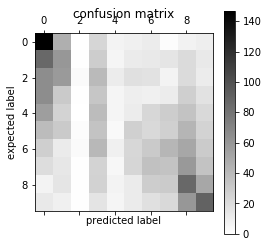

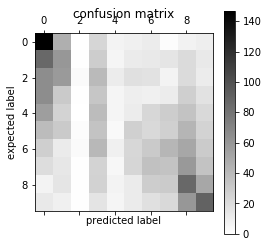

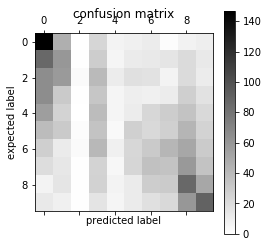

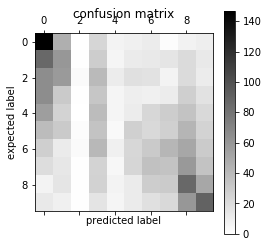

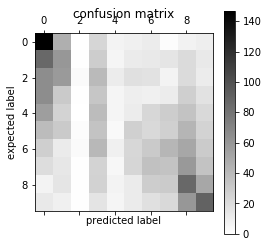

In [590]:

def algos(which_group,size):
    print("BEGIN")



    """
    Index(['groupby_lastfm', 'groupby_youtube', 'year', 'song', 'artist', 'genre',
           'inverse_score', 'number_of_weeks', 'old_popularity', 'artist_rank',
           'lastfm', 'lastfm_rank', 'youtube', 'youtube_rank', 'new_total_count',
           'genre_category', 'Alternative & Punk', 'Classical', 'Electronica',
           'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional', 'Urban',
           'number_of_songs_by_artist', 'total_number_of_songs_by_artist',
           'genre_Count_from2005'],
          dtype='object')
    """
    from sklearn.cross_validation import train_test_split

    train_x, test_x, train_y, test_y = train_test_split(my_dataset[['year','genre_category','old_popularity','total_number_of_songs_by_artist','genre_Count_from2005']],
        my_dataset['groupby_3'], train_size=0.70)


    print("*****************************************LR***************************************")

    # Logistic Regression
    from sklearn import metrics
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import mean_squared_error
    result =  pd.DataFrame()
    # fit a logistic regression model to the data
    model = LogisticRegression()
    model.fit(train_x, train_y)
    print(model)
    # make predictions
    expected = test_y
    predicted = model.predict(test_x)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print("MSE : ",mean_squared_error(expected,predicted))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted, normalize=False))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted))
    result['expected'] = expected
    result['LR'] = predicted

    plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')


    print("*****************************************NB***************************************")

    # Naive Bayes
    from sklearn import metrics
    from sklearn.naive_bayes import GaussianNB
    from sklearn.metrics import mean_squared_error
    model = GaussianNB()
    model.fit(train_x, train_y)
    print(model)
    # make predictions
    expected = test_y
    predicted = model.predict(test_x)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print("MSE : ",mean_squared_error(expected,predicted))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted))
    result['NB'] = predicted

    plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')

    print("*****************************************KNN***************************************")

    # knn
    from sklearn import metrics
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import mean_squared_error
    model = KNeighborsClassifier()
    model.fit(train_x, train_y)
    print(model)
    # make predictions
    expected = test_y
    predicted = model.predict(test_x)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print("MSE : ",mean_squared_error(expected,predicted))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted))
    result['KNN'] = predicted

    plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')


    print("*****************************************DEcision Tree***************************************")

    # DEcision Tree
    from sklearn import metrics
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import mean_squared_error
    model = DecisionTreeClassifier()
    model.fit(train_x, train_y)
    print(model)
    # make predictions
    expected = test_y
    predicted = model.predict(test_x)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print("MSE : ",mean_squared_error(expected,predicted))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted,normalize=False))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted))
    result['DT'] = predicted

    plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')
    print("*****************************************SVM***************************************")

    # SVM
    from sklearn import metrics
    from sklearn.svm import SVC
    from sklearn.metrics import mean_squared_error
    model = SVC()
    model.fit(train_x, train_y)
    print(model)
    # make predictions
    expected = test_y
    predicted = model.predict(test_x)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print("MSE : ",mean_squared_error(expected,predicted))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted,normalize=False))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted))
    result['SVC'] = predicted


    plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')
    print("END")

In [525]:
my_dataset.to_csv('my_dataset.csv',index = False)
result.to_csv('result.csv',index = False)

In [541]:
result.shape

(2481, 6)

Text(0.5,0,'predicted label')

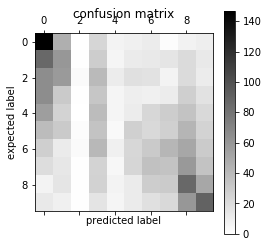

In [542]:

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [552]:
k = 5
my_dataset['groupby_5'] = k
row = my_dataset.shape[0]
print(row)
for i in range(1,k):
    print((1+(row/k)*(i-1)),"  ",(row/k)*i)
    my_dataset['groupby_5'].iloc[ (my_dataset.index >= int((1 + (i-1)*(row/k)))) & (my_dataset.index <= int((row/k)*i))] = i
print("end")

8267
1.0    1653.4


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1654.4    3306.8
3307.8    4960.200000000001
4961.200000000001    6613.6
end


In [553]:
my_dataset

,groupby_lastfm,groupby_youtube,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,artist_rank,...,Pop,Rock,Soundtrack,Traditional,Urban,number_of_songs_by_artist,total_number_of_songs_by_artist,genre_Count_from2005,groupby_3,groupby_5
1,1,1,1969,Suspicious Minds,Elvis Presley,Rock,1210,15,277,25,...,0,1,0,0,0,742,985,1990,1,1
2,1,1,1969,In The Ghetto,Elvis Presley,Rock,1053,13,615,25,...,0,1,0,0,0,742,985,1990,1,1
3,1,1,1970,Kentucky Rain,Elvis Presley,Rock,618,9,2108,25,...,0,1,0,0,0,742,985,1990,1,1
4,1,1,1964,Viva Las Vegas,Elvis Presley,Rock,9,1,7747,25,...,0,1,0,0,0,742,985,1990,1,1
5,2,1,1962,Follow That Dream,Elvis Presley,Rock,662,10,1940,25,...,0,1,0,0,0,742,985,1990,1,1
6,2,1,1969,Memories,Elvis Presley,Rock,388,7,3338,25,...,0,1,0,0,0,742,985,1990,1,1
7,1,1,1961,Little Sister,Elvis Presley,Rock,981,13,805,25,...,0,1,0,0,0,742,985,1990,1,1
8,1,1,1968,If I Can Dream,Elvis Presley,Rock,892,13,1073,25,...,0,1,0,0,0,742,985,1990,1,1
9,1,1,1961,(Marie's The Name) His Latest Flame,Elvis Presley,Rock,755,11,1578,25,...,0,1,0,0,0,742,985,1990,1,1
10,1,1,1966,Love Letters,Elvis Presley,Rock,470,7,2816,25,...,0,1,0,0,0,742,985,1990,1,1


In [544]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(train_x)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[  4.82079208e+00   7.76237624e+00   1.96425743e+03   4.12079967e+03
    1.14795710e+02   1.83757327e+03]
 [  7.54862119e+00   7.63969521e+00   1.96442199e+03   4.29618650e+03
    1.35293904e+02   1.61011684e+04]]
[1 1 1 ..., 0 0 0]


In [557]:
my_dataset = pd.merge(my_dataset,rank_by_youtube[['song','artist','groupby_youtube']], how = 'inner' , on = ['song','artist'])

In [559]:
my_dataset.drop('groupby_youtube_x',axis = 1 ,inplace = True)
my_dataset.rename(columns = {'groupby_youtube_y' : 'groupby_youtube'},inplace = True)

In [561]:
my_dataset.columns

Index(['groupby_lastfm', 'year', 'song', 'artist', 'genre', 'inverse_score',
       'number_of_weeks', 'old_popularity', 'artist_rank', 'lastfm',
       'lastfm_rank', 'youtube', 'youtube_rank', 'new_total_count',
       'genre_category', 'Alternative & Punk', 'Classical', 'Electronica',
       'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional', 'Urban',
       'number_of_songs_by_artist', 'total_number_of_songs_by_artist',
       'genre_Count_from2005', 'groupby_3', 'groupby_5', 'groupby_youtube'],
      dtype='object')

In [572]:
my_dataset = my_dataset.sort_values('youtube_rank',ascending=True)

In [573]:
my_dataset.reset_index(inplace = True)

In [574]:
my_dataset.index =  my_dataset.index  + 1

In [576]:
my_dataset.drop('index' ,axis = 1,inplace= True)

In [577]:
my_dataset

,groupby_lastfm,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,artist_rank,lastfm,...,Other,Pop,Rock,Soundtrack,Traditional,Urban,number_of_songs_by_artist,total_number_of_songs_by_artist,genre_Count_from2005,groupby_youtube
1,1,1964,The House Of The Rising Sun,The Animals,Rock,963,11,863,181,4600463,...,0,0,1,0,0,0,86,96,1990,1
2,1,1965,The Sound Of Silence,Simon & Garfunkel,Pop,1092,14,513,89,7006004,...,0,1,0,0,0,0,142,176,13616,1
3,1,1966,California Dreamin',The Mamas & The Papas,Pop,1265,17,195,119,3842033,...,0,1,0,0,0,0,118,121,13616,1
4,1,1961,Stand By Me,Ben E. King,Urban,1061,14,591,111,2744255,...,0,0,0,0,0,1,124,163,19436,1
5,1,1966,These Boots Are Made For Walkin',Nancy Sinatra,Rock,1157,14,364,146,803381,...,0,0,1,0,0,0,108,108,1990,1
6,10,1960,I Need You Now,100 Strings and Jono (Choir of 40 Voices),Rock,3,1,8214,2367,0,...,0,0,0,0,0,0,1,1,1990,1
7,10,1965,4 - By The Beatles,The Beatles,Rock,136,5,5478,1,1,...,0,0,1,0,0,0,530,608,1990,1
8,1,1968,Hey Jude,The Beatles,Rock,1770,19,14,1,5506995,...,0,0,1,0,0,0,530,608,1990,1
9,1,1967,A Whiter Shade Of Pale,Procol Harum,Rock,977,12,824,877,1674118,...,0,0,1,0,0,0,17,30,1990,1
10,1,1961,Let's Twist Again,Chubby Checker,Rock,1504,23,52,13,547943,...,0,0,1,0,0,0,302,307,1990,1


In [578]:
k = 5
my_dataset['groupby_5'] = k
row = my_dataset.shape[0]
print(row)
for i in range(1,k):
    print((1+(row/k)*(i-1)),"  ",(row/k)*i)
    my_dataset['groupby_5'].iloc[ (my_dataset.index >= int((1 + (i-1)*(row/k)))) & (my_dataset.index <= int((row/k)*i))] = i
print("end")

8267
1.0    1653.4


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1654.4    3306.8
3307.8    4960.200000000001
4961.200000000001    6613.6
end


In [581]:
k = 3
my_dataset['groupby_3'] = k
row = my_dataset.shape[0]
print(row)
for i in range(1,k):
    print((1+(row/k)*(i-1)),"  ",(row/k)*i)
    my_dataset['groupby_3'].iloc[ (my_dataset.index >= int((1 + (i-1)*(row/k)))) & (my_dataset.index <= int((row/k)*i))] = i
print("end")

8267
1.0    2755.6666666666665


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2756.6666666666665    5511.333333333333
end


In [594]:
my_dataset = my_dataset.sort_values('new_total_count',ascending=False)

In [596]:
my_dataset.reset_index(inplace = True)

my_dataset.index =  my_dataset.index  + 1

my_dataset.drop('index' ,axis = 1,inplace= True)

my_dataset['rankby_total_count'] = my_dataset.index

In [597]:
my_dataset

,groupby_lastfm,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,artist_rank,lastfm,...,Soundtrack,Traditional,Urban,number_of_songs_by_artist,total_number_of_songs_by_artist,genre_Count_from2005,groupby_youtube,groupby_5,groupby_3,rankby_total_count
1,1,1964,The House Of The Rising Sun,The Animals,Rock,963,11,863,181,4600463,...,0,0,0,86,96,1990,1,1,1,1
2,1,1965,The Sound Of Silence,Simon & Garfunkel,Pop,1092,14,513,89,7006004,...,0,0,0,142,176,13616,1,1,1,2
3,1,1966,California Dreamin',The Mamas & The Papas,Pop,1265,17,195,119,3842033,...,0,0,0,118,121,13616,1,1,1,3
4,1,1961,Stand By Me,Ben E. King,Urban,1061,14,591,111,2744255,...,0,0,1,124,163,19436,1,1,1,4
5,1,1966,These Boots Are Made For Walkin',Nancy Sinatra,Rock,1157,14,364,146,803381,...,0,0,0,108,108,1990,1,1,1,5
6,1,1968,Hey Jude,The Beatles,Rock,1770,19,14,1,5506995,...,0,0,0,530,608,1990,1,1,1,6
7,10,1960,I Need You Now,100 Strings and Jono (Choir of 40 Voices),Rock,3,1,8214,2367,0,...,0,0,0,1,1,1990,1,1,1,7
8,10,1965,4 - By The Beatles,The Beatles,Rock,136,5,5478,1,1,...,0,0,0,530,608,1990,1,1,1,8
9,1,1966,"Paint It, Black",The Rolling Stones,Pop,963,11,862,32,6971647,...,0,0,0,218,585,13616,1,1,1,9
10,1,1967,A Whiter Shade Of Pale,Procol Harum,Rock,977,12,824,877,1674118,...,0,0,0,17,30,1990,1,1,1,10


In [598]:
k = 3
my_dataset['groupby_3_total_rank'] = k
row = my_dataset.shape[0]
print(row)
for i in range(1,k):
    print((1+(row/k)*(i-1)),"  ",(row/k)*i)
    my_dataset['groupby_3_total_rank'].iloc[ (my_dataset.index >= int((1 + (i-1)*(row/k)))) & (my_dataset.index <= int((row/k)*i))] = i
print("end")

k = 5
my_dataset['groupby_5_total_rank'] = k
row = my_dataset.shape[0]
print(row)
for i in range(1,k):
    print((1+(row/k)*(i-1)),"  ",(row/k)*i)
    my_dataset['groupby_5_total_rank'].iloc[ (my_dataset.index >= int((1 + (i-1)*(row/k)))) & (my_dataset.index <= int((row/k)*i))] = i
print("end")

8267
1.0    2755.6666666666665


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2756.6666666666665    5511.333333333333
end
8267
1.0    1653.4
1654.4    3306.8
3307.8    4960.200000000001
4961.200000000001    6613.6
end


In [601]:
my_dataset[['number_of_songs_by_artist', 'total_number_of_songs_by_artist']]


,number_of_songs_by_artist,total_number_of_songs_by_artist
1,86,96
2,142,176
3,118,121
4,124,163
5,108,108
6,530,608
7,1,1
8,530,608
9,218,585
10,17,30


BEGIN
*****************************************LR***************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.56      0.71      0.63       815
          2       0.39      0.17      0.24       809
          3       0.55      0.70      0.62       857

avg / total       0.50      0.53      0.50      2481

[[578  88 149]
 [320 140 349]
 [126 128 603]]
MSE :  0.800080612656
Accuracy :  1321
Accuracy :  0.532446594115
*****************************************NB***************************************
GaussianNB(priors=None)
             precision    recall  f1-score   support

          1       0.63      0.64      0.64       815
          2       0.43      0.26      0.32       809

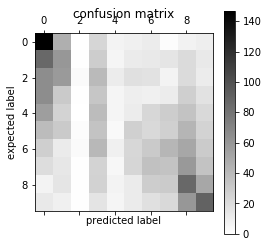

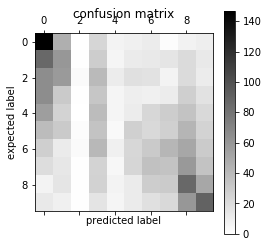

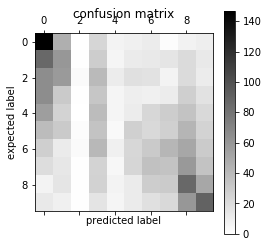

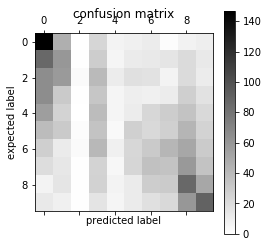

In [617]:


print("BEGIN")



"""
Index(['groupby_lastfm', 'groupby_youtube', 'year', 'song', 'artist', 'genre',
       'inverse_score', 'number_of_weeks', 'old_popularity', 'artist_rank',
       'lastfm', 'lastfm_rank', 'youtube', 'youtube_rank', 'new_total_count',
       'genre_category', "Alternative & Punk", 'Classical', 'Electronica',
       'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional', 'Urban',
       'number_of_songs_by_artist', 'total_number_of_songs_by_artist',
       'genre_Count_from2005'],
      dtype='object')
"""
from sklearn.cross_validation import train_test_split

train_x, test_x, train_y, test_y = train_test_split(my_dataset[['number_of_weeks','inverse_score','old_popularity',
                                                                'total_number_of_songs_by_artist','full_gerne_count',
                                                                "Alternative & Punk", 'Classical', 'Electronica',
                                                                'Jazz', 'Other', 'Pop', 'Rock', 
                                                                'Soundtrack', 'Traditional', 'Urban','genre_category']],
    my_dataset['groupby_3_total_rank'], train_size=0.70)


print("*****************************************LR***************************************")

# Logistic Regression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
result =  pd.DataFrame()
# fit a logistic regression model to the data
model = LogisticRegression()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted, normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['expected'] = expected
result['LR'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')


print("*****************************************NB***************************************")

# Naive Bayes
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
model = GaussianNB()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['NB'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

print("*****************************************KNN***************************************")

# knn
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
model = KNeighborsClassifier()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['KNN'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')


print("*****************************************DEcision Tree***************************************")

# DEcision Tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
model = DecisionTreeClassifier()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted,normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['DT'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

"""
print("*****************************************SVM***************************************")

# SVM
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
model = SVC()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted,normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['SVC'] = predicted


plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
"""
print("END")

In [603]:
result

,expected,LR,NB,KNN,DT
2429,2,1,1,1,3
1657,2,2,2,3,1
7226,5,4,4,5,3
3387,3,5,5,5,5
8255,5,1,1,2,1
263,1,3,4,4,2
3454,3,1,1,1,2
5015,4,3,4,3,5
1728,2,1,3,4,2
6753,5,5,5,1,4


In [606]:
gerne_count_full = all_genre_year.groupby('genre').count().reset_index()
gerne_count_full.index = gerne_count_full.index + 1

In [607]:
gerne_count_full

,genre,song,artist,date,position,year
1,Alternative & Punk,19496,19496,19496,19496,19496
2,Classical,376,376,376,376,376
3,Electronica,10931,10931,10931,10931,10931
4,Jazz,4100,4100,4100,4100,4100
5,Nan,12870,12870,12870,12870,12870
6,Other,7389,7389,7389,7389,7389
7,Pop,51581,51581,51581,51581,51581
8,Rock,75454,75454,75454,75454,75454
9,Soundtrack,1188,1188,1188,1188,1188
10,Traditional,31582,31582,31582,31582,31582


In [608]:
gerne_count_full.drop(['artist', 	'date', 	'position', 	'year'],axis = 1,inplace = True)
gerne_count_full.rename(columns = {'song' : 'full_gerne_count'},inplace = True)

In [610]:
my_dataset = pd.merge(my_dataset,gerne_count_full,how = 'inner' , on = 'genre')

In [619]:
my_dataset.to_csv('my_dataset_final.csv',index = False)

In [620]:
my_dataset['genre_category'] = my_dataset['genre'].astype('category').cat.codes

In [621]:
artist_sort = my_dataset.sort_values(['total_number_of_songs_by_artist'],ascending = False)

In [623]:
artist_sort.reset_index(inplace =True)
artist_sort.index =  artist_sort.index  + 1

In [625]:
artist_sort.drop('index',axis = 1,inplace = True)

In [627]:
k = 3
artist_sort['groupby_3_artist'] = k
row = artist_sort.shape[0]
print(row)
for i in range(1,k):
    print((1+(row/k)*(i-1)),"  ",(row/k)*i)
    artist_sort['groupby_3_artist'].iloc[ (artist_sort.index >= int((1 + (i-1)*(row/k)))) & (artist_sort.index <= int((row/k)*i))] = i
print("end")

k = 5
artist_sort['groupby_5_artist'] = k
row = artist_sort.shape[0]
print(row)
for i in range(1,k):
    print((1+(row/k)*(i-1)),"  ",(row/k)*i)
    artist_sort['groupby_5_artist'].iloc[ (artist_sort.index >= int((1 + (i-1)*(row/k)))) & (artist_sort.index <= int((row/k)*i))] = i
print("end")

8267
1.0    2755.6666666666665


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2756.6666666666665    5511.333333333333
end
8267
1.0    1653.4
1654.4    3306.8
3307.8    4960.200000000001
4961.200000000001    6613.6
end


In [628]:
artist_sort

,groupby_lastfm,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,artist_rank,lastfm,...,genre_Count_from2005,groupby_youtube,groupby_5,groupby_3,rankby_total_count,groupby_3_total_rank,groupby_5_total_rank,full_gerne_count,groupby_3_artist,groupby_5_artist
1,3,1964,Ain't That Loving You Baby,Elvis Presley,Rock,691,10,1823,25,37352,...,1990,3,2,1,1863,1,2,75454,1,1
2,1,1958,One Night,Elvis Presley,Rock,1304,17,153,25,456362,...,1990,5,3,2,1487,1,1,75454,1,1
3,1,1966,Love Letters,Elvis Presley,Rock,470,7,2816,25,140181,...,1990,2,1,1,1195,1,1,75454,1,1
4,4,1966,Frankie And Johnny,Elvis Presley,Rock,476,8,2789,25,15927,...,1990,3,2,1,2170,1,2,75454,1,1
5,2,1962,Follow That Dream,Elvis Presley,Rock,662,10,1940,25,57971,...,1990,1,1,1,345,1,1,75454,1,1
6,1,1961,Little Sister,Elvis Presley,Rock,981,13,805,25,201645,...,1990,1,1,1,832,1,1,75454,1,1
7,10,1970,I Really Don't Want To Know/There Goes My Ever...,Elvis Presley,Rock,45,1,6625,25,0,...,1990,7,4,3,6160,3,4,75454,1,1
8,3,1967,Judy,Elvis Presley,Rock,90,5,5984,25,19962,...,1990,4,2,2,3225,2,2,75454,1,1
9,10,1969,Don't Cry Daddy/Rubberneckin',Elvis Presley,Rock,1013,13,707,25,0,...,1990,10,5,3,8216,3,5,75454,1,1
10,1,1970,Kentucky Rain,Elvis Presley,Rock,618,9,2108,25,187199,...,1990,1,1,1,259,1,1,75454,1,1


BEGIN
*****************************************LR***************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.86      0.95      0.90       517
          2       0.81      0.74      0.77       489
          3       0.86      0.75      0.80       509
          4       0.85      0.87      0.86       494
          5       0.91      0.98      0.94       472

avg / total       0.86      0.86      0.86      2481

[[492  25   0   0   0]
 [ 82 364  42   1   0]
 [  0  62 383  64   0]
 [  0   0  18 431  45]
 [  0   0   0   9 463]]
MSE :  0.141475211608
Accuracy :  2133
Accuracy :  0.859733978235
*****************************************NB***************************************
Gaussia

Text(0.5,0,'predicted label')

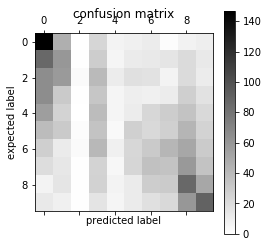

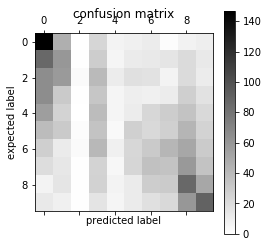

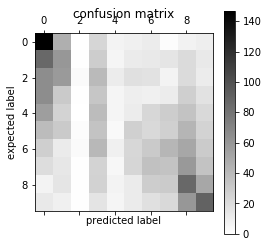

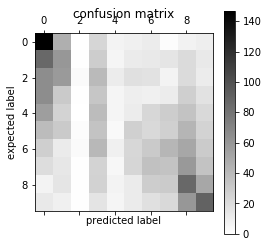

In [673]:

print("BEGIN")



"""
Index(['groupby_lastfm', 'groupby_youtube', 'year', 'song', 'artist', 'genre',
       'inverse_score', 'number_of_weeks', 'old_popularity', 'artist_rank',
       'lastfm', 'lastfm_rank', 'youtube', 'youtube_rank', 'new_total_count',
       'genre_category', "Alternative & Punk", 'Classical', 'Electronica',
       'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional', 'Urban',
       'number_of_songs_by_artist', 'total_number_of_songs_by_artist',
       'genre_Count_from2005'],
      dtype='object')
"""
from sklearn.cross_validation import train_test_split

train_x, test_x, train_y, test_y = train_test_split(artist_sort[['number_of_weeks','inverse_score','old_popularity',
                                                                'total_number_of_songs_by_artist','full_gerne_count',
                                                                'genre_category']],
    artist_sort['groupby_5_artist'], train_size=0.70)


print("*****************************************LR***************************************")

# Logistic Regression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
result =  pd.DataFrame()
# fit a logistic regression model to the data
model = LogisticRegression()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted, normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['expected'] = expected
result['LR'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')


print("*****************************************NB***************************************")

# Naive Bayes
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
model = GaussianNB()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['NB'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

print("*****************************************KNN***************************************")

# knn
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
model = KNeighborsClassifier()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['KNN'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')


print("*****************************************DEcision Tree***************************************")

# DEcision Tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
model = DecisionTreeClassifier()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted,normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['DT'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')


In [631]:
k = 10
artist_sort['groupby_10_artist'] = k
row = artist_sort.shape[0]
print(row)
for i in range(1,k):
    print((1+(row/k)*(i-1)),"  ",(row/k)*i)
    artist_sort['groupby_10_artist'].iloc[ (artist_sort.index >= int((1 + (i-1)*(row/k)))) & (artist_sort.index <= int((row/k)*i))] = i
print("end")


8267
1.0    826.7


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


827.7    1653.4
1654.4    2480.1000000000004
2481.1000000000004    3306.8
3307.8    4133.5
4134.5    4960.200000000001
4961.200000000001    5786.900000000001
5787.900000000001    6613.6
6614.6    7440.3
end


BEGIN
*****************************************LR***************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       0.54      0.95      0.68       253
          2       0.27      0.46      0.34       249
          3       0.38      0.12      0.18       273
          4       0.19      0.10      0.13       247
          5       0.46      0.63      0.53       238
          6       0.43      0.28      0.34       244
          7       0.59      0.69      0.64       226
          8       0.73      0.59      0.65       229
          9       0.86      0.37      0.52       259
         10       0.73      0.97      0.83       263

avg / total       0.52      0.51      0.48      2481

[[240  

Text(0.5,0,'predicted label')

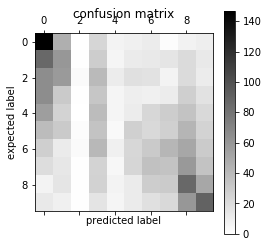

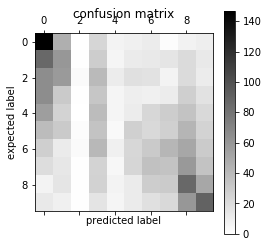

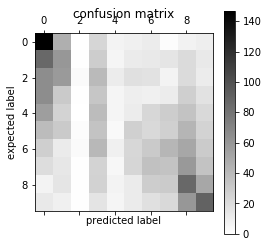

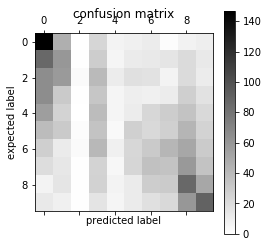

In [676]:

print("BEGIN")



"""
Index(['groupby_lastfm', 'groupby_youtube', 'year', 'song', 'artist', 'genre',
       'inverse_score', 'number_of_weeks', 'old_popularity', 'artist_rank',
       'lastfm', 'lastfm_rank', 'youtube', 'youtube_rank', 'new_total_count',
       'genre_category', "Alternative & Punk", 'Classical', 'Electronica',
       'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional', 'Urban',
       'number_of_songs_by_artist', 'total_number_of_songs_by_artist',
       'genre_Count_from2005'],
      dtype='object')
"""
from sklearn.cross_validation import train_test_split

train_x, test_x, train_y, test_y = train_test_split(artist_sort[['old_popularity',
                                                                'total_number_of_songs_by_artist','full_gerne_count',
                                                                'genre_category']],
    artist_sort['groupby_10_artist'], train_size=0.70)


print("*****************************************LR***************************************")

# Logistic Regression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
result =  pd.DataFrame()
# fit a logistic regression model to the data
model = LogisticRegression()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted, normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['expected'] = expected
result['LR'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')


print("*****************************************NB***************************************")

# Naive Bayes
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
model = GaussianNB()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['NB'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

print("*****************************************KNN***************************************")

# knn
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
model = KNeighborsClassifier()
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['KNN'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')


print("*****************************************DEcision Tree***************************************")

# DEcision Tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
model = DecisionTreeClassifier(criterion='gini')
model.fit(train_x, train_y)
print(model)
# make predictions
expected = test_y
predicted = model.predict(test_x)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print("MSE : ",mean_squared_error(expected,predicted))
print("Accuracy : ",metrics.accuracy_score(expected,predicted,normalize=False))
print("Accuracy : ",metrics.accuracy_score(expected,predicted))
result['DT'] = predicted

plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')


In [677]:

artist_sort[artist_sort['song'] == 'Good Vibrations']

,groupby_lastfm,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,artist_rank,lastfm,...,groupby_youtube,groupby_5,groupby_3,rankby_total_count,groupby_3_total_rank,groupby_5_total_rank,full_gerne_count,groupby_3_artist,groupby_5_artist,groupby_10_artist
214,1,1966,Good Vibrations,The Beach Boys,Rock,1155,14,367,6,2643834,...,1,1,1,112,1,1,75454,1,1,1


In [678]:
test_x[test_x['old_popularity'] == 367]

,old_popularity,total_number_of_songs_by_artist,full_gerne_count,genre_category


In [653]:
model.predict(test_x[test_x['old_popularity'] == 367])

array([1])

In [661]:
artist_sort[artist_sort['song'] == 'The Ballad Of The Green Berets']

,groupby_lastfm,year,song,artist,genre,inverse_score,number_of_weeks,old_popularity,artist_rank,lastfm,...,groupby_youtube,groupby_5,groupby_3,rankby_total_count,groupby_3_total_rank,groupby_5_total_rank,full_gerne_count,groupby_3_artist,groupby_5_artist,groupby_10_artist
6300,3,1966,The Ballad Of The Green Berets,SSgt Barry Sadler,Rock,1108,13,466,742,27851,...,1,1,1,217,1,1,75454,3,4,8


In [675]:
artist_sort.to_csv('artist_sort.csv',index= False)

In [686]:
def algos(which_group,size):
    print("BEGIN")
    """
    Index(['groupby_lastfm', 'groupby_youtube', 'year', 'song', 'artist', 'genre',
           'inverse_score', 'number_of_weeks', 'old_popularity', 'artist_rank',
           'lastfm', 'lastfm_rank', 'youtube', 'youtube_rank', 'new_total_count',
           'genre_category', 'Alternative & Punk', 'Classical', 'Electronica',
           'Jazz', 'Other', 'Pop', 'Rock', 'Soundtrack', 'Traditional', 'Urban',
           'number_of_songs_by_artist', 'total_number_of_songs_by_artist',
           'genre_Count_from2005'],
          dtype='object')
    """
    from sklearn.cross_validation import train_test_split

    train_x, test_x, train_y, test_y = train_test_split(artist_sort[['year','genre_category','old_popularity','total_number_of_songs_by_artist','genre_Count_from2005']],
        artist_sort[which_group], train_size=size)


    print("*****************************************LR***************************************")

    # Logistic Regression
    from sklearn import metrics
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import mean_squared_error
    result =  pd.DataFrame()
    # fit a logistic regression model to the data
    model = LogisticRegression()
    model.fit(train_x, train_y)
    print(model)
    # make predictions
    expected = test_y
    predicted = model.predict(test_x)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print("MSE : ",mean_squared_error(expected,predicted))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted, normalize=False))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted))
    result['expected'] = expected
    result['LR'] = predicted

    plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')


    print("*****************************************NB***************************************")

    # Naive Bayes
    from sklearn import metrics
    from sklearn.naive_bayes import GaussianNB
    from sklearn.metrics import mean_squared_error
    model = GaussianNB()
    model.fit(train_x, train_y)
    print(model)
    # make predictions
    expected = test_y
    predicted = model.predict(test_x)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print("MSE : ",mean_squared_error(expected,predicted))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted))
    result['NB'] = predicted

    plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')

    print("*****************************************KNN***************************************")

    # knn
    from sklearn import metrics
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import mean_squared_error
    model = KNeighborsClassifier()
    model.fit(train_x, train_y)
    print(model)
    # make predictions
    expected = test_y
    predicted = model.predict(test_x)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print("MSE : ",mean_squared_error(expected,predicted))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted ,normalize=False))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted))
    result['KNN'] = predicted

    plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')


    print("*****************************************DEcision Tree***************************************")

    # DEcision Tree
    from sklearn import metrics
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import mean_squared_error
    model = DecisionTreeClassifier()
    model.fit(train_x, train_y)
    print(model)
    # make predictions
    expected = test_y
    predicted = model.predict(test_x)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print("MSE : ",mean_squared_error(expected,predicted))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted,normalize=False))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted))
    result['DT'] = predicted

    plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')
    print("*****************************************SVM***************************************")

    # SVM
    from sklearn import metrics
    from sklearn.svm import SVC
    from sklearn.metrics import mean_squared_error
    model = SVC()
    model.fit(train_x, train_y)
    print(model)
    # make predictions
    expected = test_y
    predicted = model.predict(test_x)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print("MSE : ",mean_squared_error(expected,predicted))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted,normalize=False))
    print("Accuracy : ",metrics.accuracy_score(expected,predicted))
    result['SVC'] = predicted


    plt.matshow(confusion_matrix, cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')
    print("END")
    


BEGIN
*****************************************LR***************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          1       1.00      1.00      1.00       165
          2       0.61      0.76      0.68       165
          3       0.50      0.52      0.51       170
          4       0.58      0.44      0.50       157
          5       0.69      0.64      0.66       174
          6       0.58      0.58      0.58       163
          7       0.48      0.52      0.50       156
          8       0.57      0.51      0.54       153
          9       0.72      0.70      0.71       178
         10       0.89      0.94      0.92       173

avg / total       0.67      0.67      0.66      1654

[[165  

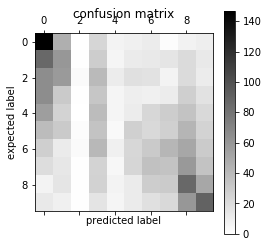

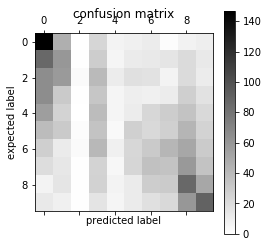

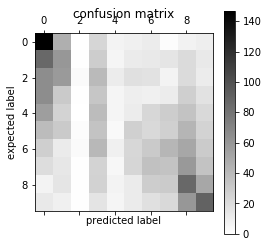

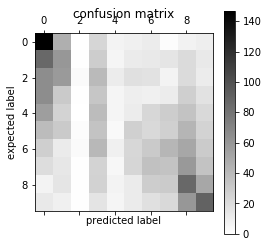

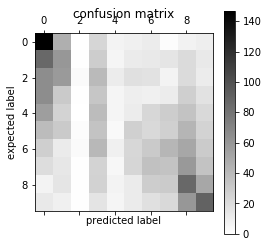

In [687]:
algos("groupby_10_artist",0.8)

In [688]:
hot[hot['song'] == 'The Fool On The Hill']

,date,position,song,artist,year
52248,1968-08-10,61,The Fool On The Hill,Sergio Mendes & Brasil '66,1968
52335,1968-08-17,48,The Fool On The Hill,Sergio Mendes & Brasil '66,1968
52419,1968-08-24,32,The Fool On The Hill,Sergio Mendes & Brasil '66,1968
52505,1968-08-31,18,The Fool On The Hill,Sergio Mendes & Brasil '66,1968
52604,1968-09-07,17,The Fool On The Hill,Sergio Mendes & Brasil '66,1968
52698,1968-09-14,11,The Fool On The Hill,Sergio Mendes & Brasil '66,1968
52795,1968-09-21,8,The Fool On The Hill,Sergio Mendes & Brasil '66,1968
52893,1968-09-28,6,The Fool On The Hill,Sergio Mendes & Brasil '66,1968
53000,1968-10-05,13,The Fool On The Hill,Sergio Mendes & Brasil '66,1968
53109,1968-10-12,22,The Fool On The Hill,Sergio Mendes & Brasil '66,1968
